# **Projet élec :** Anticipez les besoins en consommation électrique de bâtiments

## Notebook d'évaluation des modèles supervisées

### Imports

In [14]:
import statistics

In [15]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [16]:
# sklearn import
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, GridSearchCV
from sklearn import model_selection
from sklearn import metrics
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings

In [17]:
from xgboost import XGBRegressor

### Configuration

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# configurations
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 200)

### Chargement des données nettoyées

In [20]:
df_final = pd.read_csv("./data/FINAL-building-energy-benchmarking.csv", sep=',', header=0).set_index('OSEBuildingID')

In [21]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1695 entries, 325 to 50226
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   BuildingType                       1695 non-null   object 
 1   PrimaryPropertyType                1695 non-null   object 
 2   CouncilDistrictCode                1695 non-null   int64  
 3   Neighborhood                       1695 non-null   object 
 4   Latitude                           1695 non-null   float64
 5   Longitude                          1695 non-null   float64
 6   YearBuilt                          1695 non-null   int64  
 7   NumberofBuildings                  1695 non-null   float64
 8   NumberofFloors                     1695 non-null   float64
 9   PropertyGFAParking                 1695 non-null   int64  
 10  PropertyGFABuilding(s)             1695 non-null   int64  
 11  ListOfAllPropertyUseTypes          1695 non-null   ob

<AxesSubplot:>

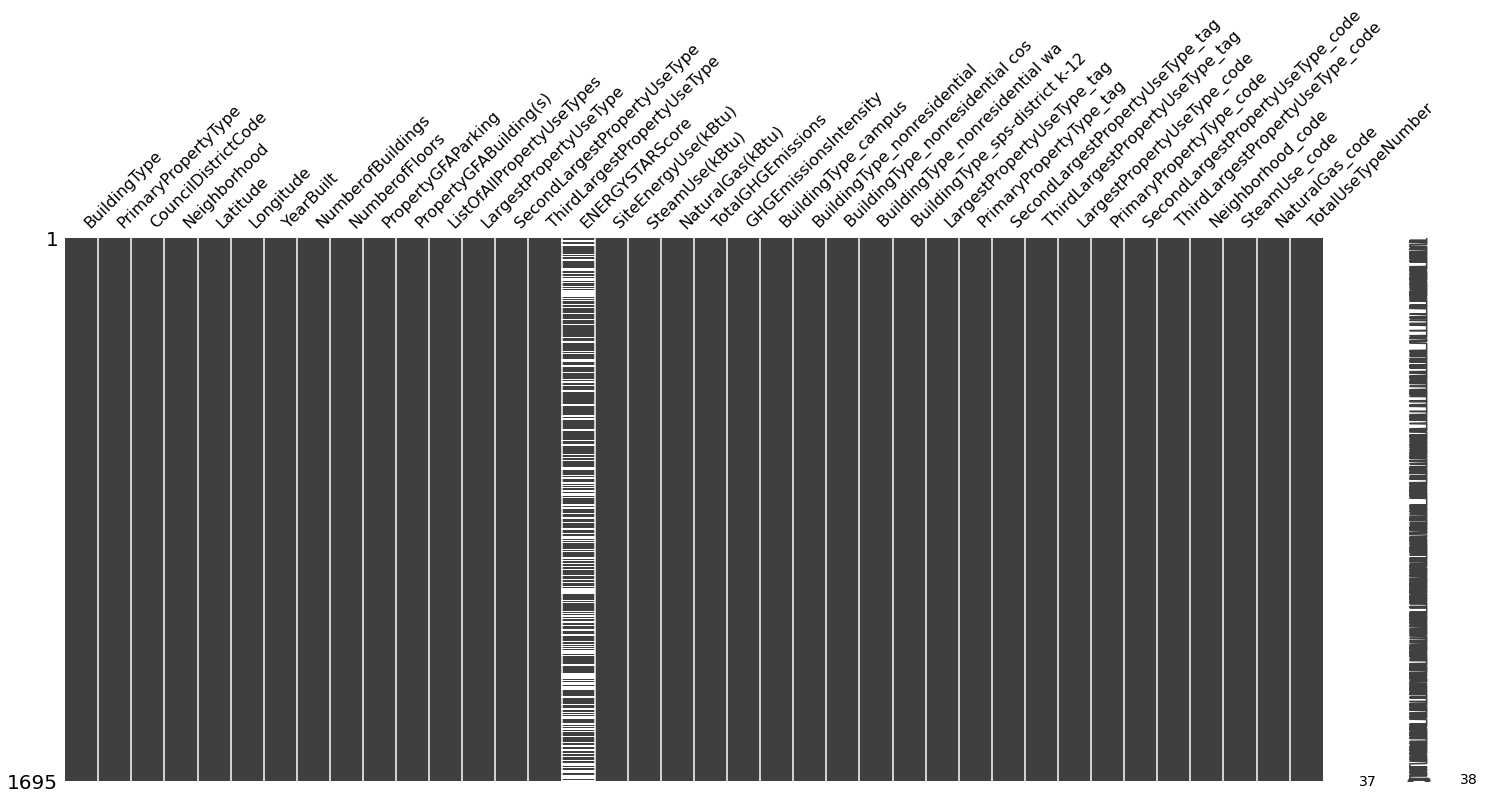

In [22]:
msno.matrix(df_final)

### Normalisation de la distribution

In [23]:
df = df_final.drop([
    'BuildingType',
    'PrimaryPropertyType',
    'Neighborhood',
    'ListOfAllPropertyUseTypes',
    'LargestPropertyUseType',
    'SecondLargestPropertyUseType',
    'ThirdLargestPropertyUseType',
    'LargestPropertyUseType_tag',
    'PrimaryPropertyType_tag',
    'SecondLargestPropertyUseType_tag',
    'ThirdLargestPropertyUseType_tag',
    'ENERGYSTARScore',
    'SteamUse(kBtu)',
    'NaturalGas(kBtu)',
], axis=1, errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1695 entries, 325 to 50226
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   CouncilDistrictCode                1695 non-null   int64  
 1   Latitude                           1695 non-null   float64
 2   Longitude                          1695 non-null   float64
 3   YearBuilt                          1695 non-null   int64  
 4   NumberofBuildings                  1695 non-null   float64
 5   NumberofFloors                     1695 non-null   float64
 6   PropertyGFAParking                 1695 non-null   int64  
 7   PropertyGFABuilding(s)             1695 non-null   int64  
 8   SiteEnergyUse(kBtu)                1695 non-null   float64
 9   TotalGHGEmissions                  1695 non-null   float64
 10  GHGEmissionsIntensity              1695 non-null   float64
 11  BuildingType_campus                1695 non-null   in

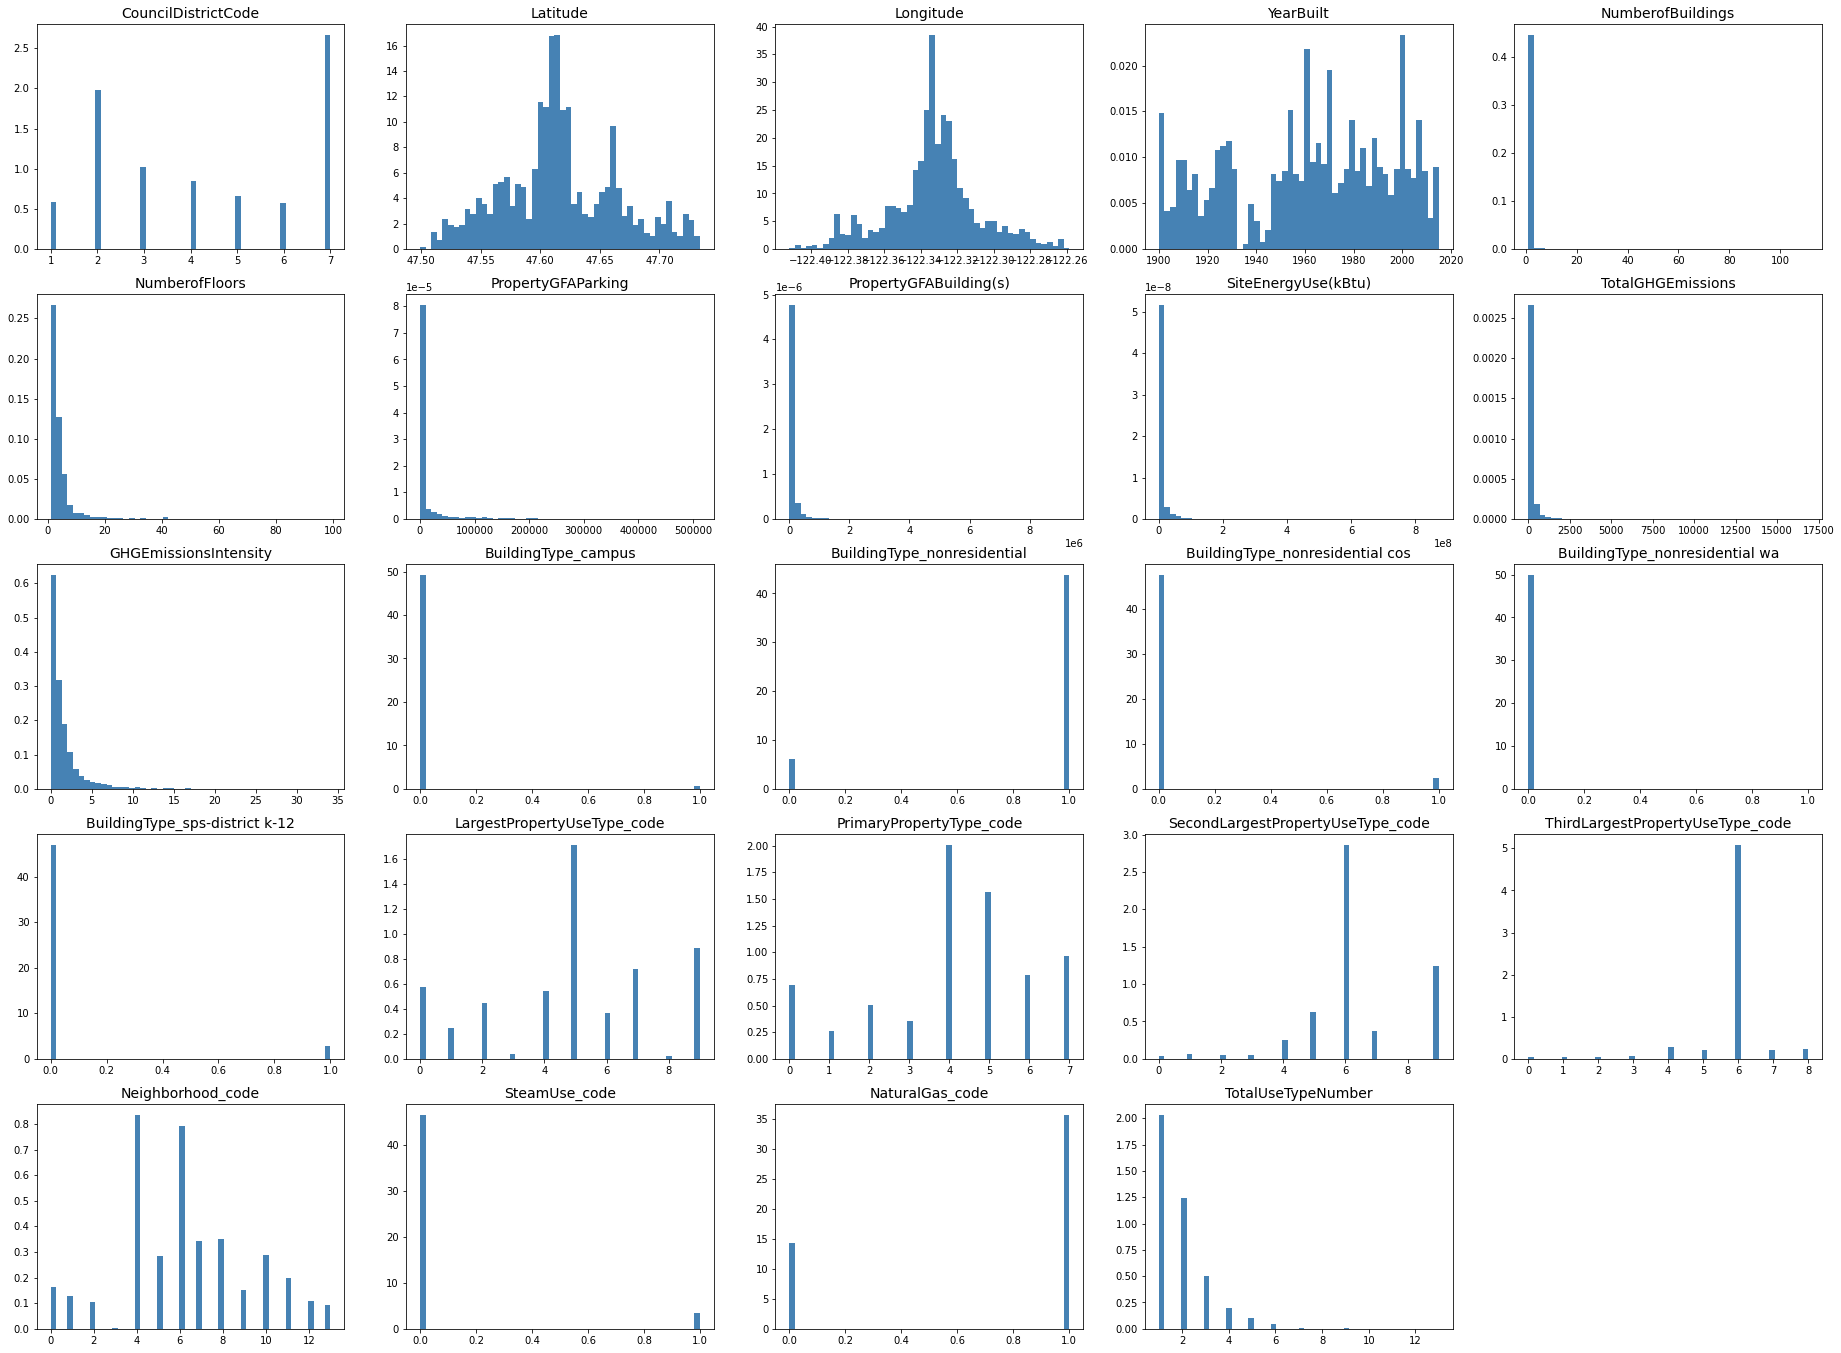

In [24]:
fig = plt.figure(figsize=(32, 24))
for i, c in enumerate(df.columns):
    ax = fig.add_subplot(5, 5, (i+1))
    h = ax.hist(df[c], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(c, fontsize=14)

In [25]:
# Selectioner uniquement les colonnes quatitatives
column_to_normalize = [
    #'CouncilDistrictCode',
    'Latitude',
    'Longitude',
    #'YearBuilt',
    'NumberofBuildings',
    'NumberofFloors',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    #'SiteEnergyUse(kBtu)', ## to predict
    #'TotalGHGEmissions',  ## to predict
    'GHGEmissionsIntensity',
    #'BuildingType_campus',
    #'BuildingType_nonresidential',
    #'BuildingType_nonresidential cos',
    #'BuildingType_nonresidential wa',
    #'BuildingType_sps-district k-12',
    #'LargestPropertyUseType_code',
    #'PrimaryPropertyType_code',
    #'SecondLargestPropertyUseType_code',
    #'ThirdLargestPropertyUseType_code',
    #'TotalUseTypeNumber',
    #'Neighborhood_code',
    #'SteamUse_code',
    #'NaturalGas_code',
]

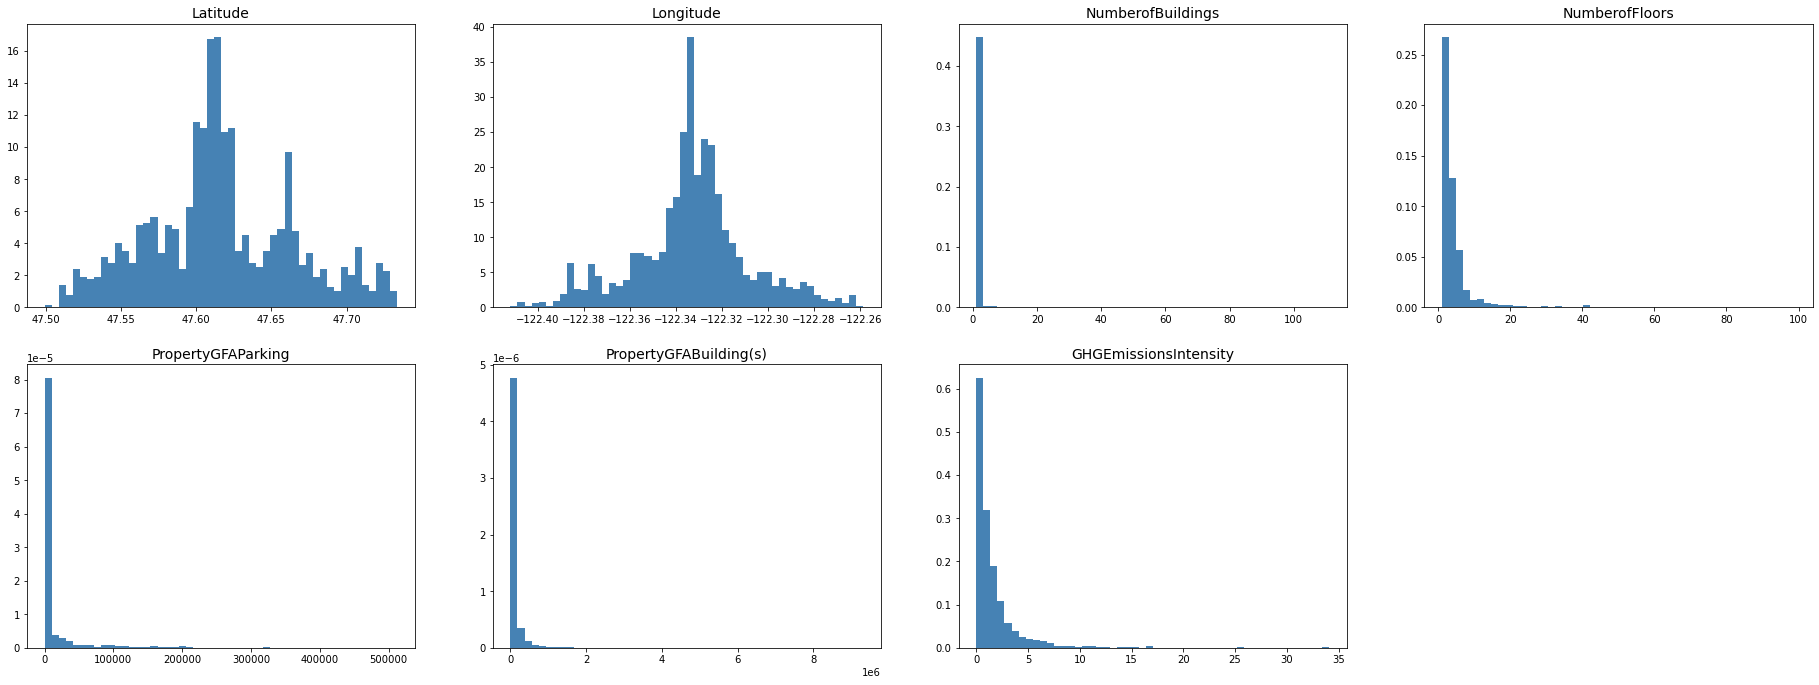

In [26]:
fig = plt.figure(figsize=(32, 24))
for i, c in enumerate(df[column_to_normalize].columns):
    ax = fig.add_subplot(4, 4, (i+1))
    h = ax.hist(df[c], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(c, fontsize=14)

In [27]:
df_scaled = StandardScaler().fit_transform(df[column_to_normalize])

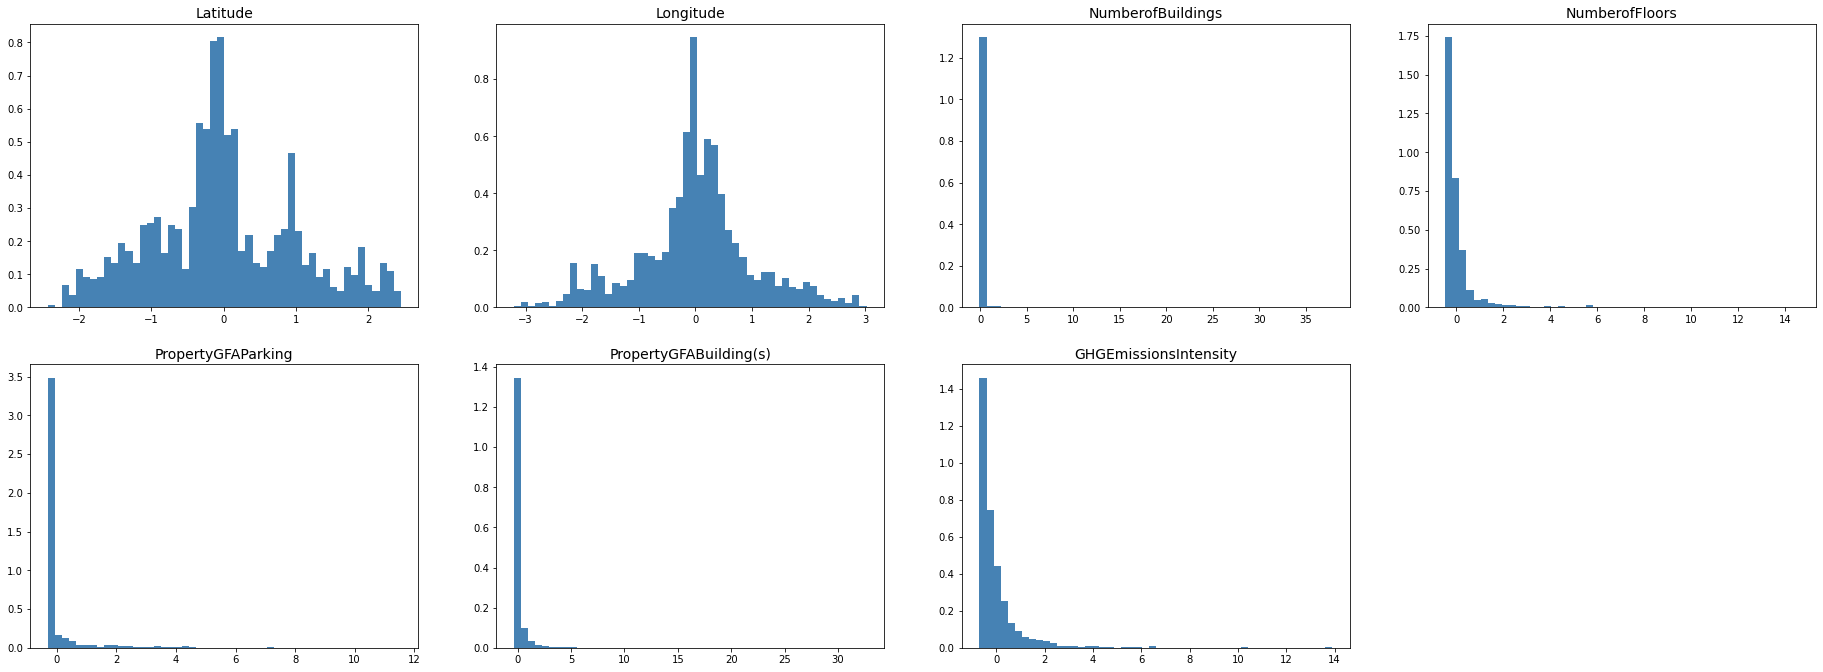

In [28]:
fig = plt.figure(figsize=(32, 24))
for i in range(df_scaled.shape[1]):
    ax = fig.add_subplot(4, 4, (i+1))
    h = ax.hist(df_scaled[:, i], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(column_to_normalize[i], fontsize=14)

### Modélisation

In [29]:
df_reg = df.copy()
df_reg[column_to_normalize] = df_scaled

df_X = df_reg.drop(['TotalGHGEmissions', 'SiteEnergyUse(kBtu)'], axis=1)
df_y = df_reg[['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']]

score_list = [
    'neg_mean_absolute_error',
    'neg_median_absolute_error',
    'neg_mean_squared_error',
    'neg_root_mean_squared_error',
    'r2'
]

energy_results_rmse = {} 
energy_results_r2 = {}

emission_results_rmse = {} 
emission_results_r2 = {}

### Analyse par une approche naive

FIT_TIME -> 0.00099945068359375
SCORE_TIME -> 0.0010003089904785157
TEST_NEG_MEAN_ABSOLUTE_ERROR -> 9849794.811226856
TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 6599194.02675351
TEST_NEG_MEAN_SQUARED_ERROR -> 928885184040815.2
TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 26582366.621139236
TEST_R2 -> 0.2977656180071587


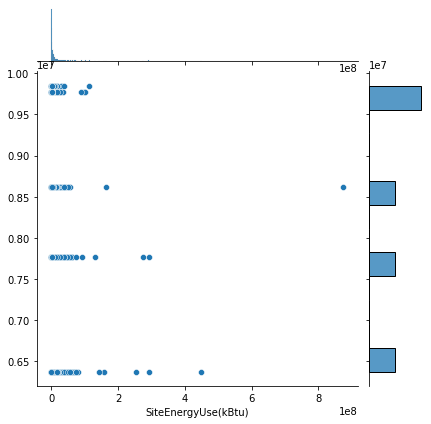

In [30]:
# Regression naive
scores = cross_validate(DummyRegressor(), df_X, df_y['SiteEnergyUse(kBtu)'], scoring=score_list, cv=5)
for k, v in scores.items():
    print(f"{k.upper()} -> {statistics.mean(abs(v))}")
baseline_error = statistics.mean(abs(scores['test_neg_mean_squared_error']))
energy_results_r2['DummyRegressor'] = statistics.mean(scores['test_r2'])
energy_results_rmse['DummyRegressor'] = statistics.mean(abs(scores['test_neg_root_mean_squared_error']))

y_pred = model_selection.cross_val_predict(DummyRegressor(), df_X, df_y['SiteEnergyUse(kBtu)'], cv=5)
_ = sns.jointplot(x = df_y['SiteEnergyUse(kBtu)'], y = y_pred)

FIT_TIME -> 0.0009993553161621095
SCORE_TIME -> 0.0010004043579101562
TEST_NEG_MEAN_ABSOLUTE_ERROR -> 228.25503988827106
TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 152.30756047197642
TEST_NEG_MEAN_SQUARED_ERROR -> 577879.1765251036
TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 668.3527858722858
TEST_R2 -> 0.12752952775202067


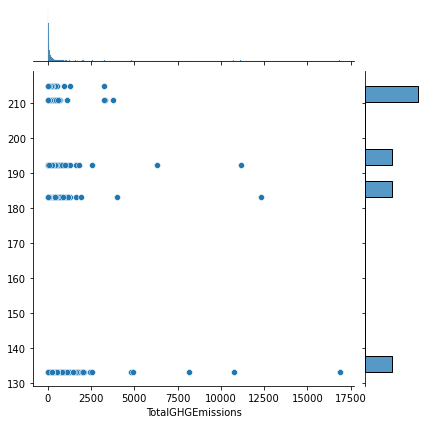

In [31]:
# Regression naive
scores = cross_validate(DummyRegressor(), df_X, df_y['TotalGHGEmissions'], scoring=score_list, cv=5)
for k, v in scores.items():
    print(f"{k.upper()} -> {statistics.mean(abs(v))}")
baseline_error = statistics.mean(abs(scores['test_neg_mean_squared_error']))
emission_results_r2['DummyRegressor'] = statistics.mean(scores['test_r2'])
emission_results_rmse['DummyRegressor'] = statistics.mean(abs(scores['test_neg_root_mean_squared_error']))

y_pred = model_selection.cross_val_predict(DummyRegressor(), df_X, df_y['TotalGHGEmissions'], cv=5)
_ = sns.jointplot(x = df_y['TotalGHGEmissions'], y = y_pred)

### Analyse des modèles linéaires (SiteEnergyUse(kBtu))

#### Régression linéaire

FIT_TIME -> 0.003200197219848633
SCORE_TIME -> 0.002401924133300781
TEST_NEG_MEAN_ABSOLUTE_ERROR -> 6110754.916187463
TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 2954369.2093819333
TEST_NEG_MEAN_SQUARED_ERROR -> 263533342372020.12
TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 14852259.914346438
TEST_R2 -> 0.6488503201838046


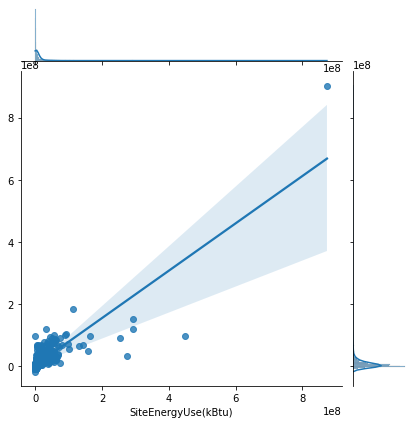

In [32]:
# regression lineaire avec cross validation (5 shards)
scores = cross_validate(LinearRegression(), df_X, df_y['SiteEnergyUse(kBtu)'], scoring=score_list, cv=5)
for k, v in scores.items():
    print(f"{k.upper()} -> {statistics.mean(abs(v))}")
baseline_error = statistics.mean(abs(scores['test_neg_mean_squared_error']))
energy_results_r2['LinearRegression'] = statistics.mean(scores['test_r2'])
energy_results_rmse['LinearRegression'] = statistics.mean(abs(scores['test_neg_root_mean_squared_error']))

y_pred = model_selection.cross_val_predict(LinearRegression(), df_X, df_y['SiteEnergyUse(kBtu)'], cv=5)
_ = sns.jointplot(x = df_y['SiteEnergyUse(kBtu)'], y = y_pred, kind="reg")

#### Régression rigide

In [33]:
# cross validation avec un alpha arbitraire (alpha=1)
scores = cross_validate(Ridge(alpha=1), df_X, df_y['SiteEnergyUse(kBtu)'], scoring=score_list, cv=5)
for k, v in scores.items():
    print(f"{k.upper()} -> {statistics.mean(abs(v))}")

FIT_TIME -> 0.0032013893127441407
SCORE_TIME -> 0.0024015426635742186
TEST_NEG_MEAN_ABSOLUTE_ERROR -> 6100579.720290806
TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 2955028.60535929
TEST_NEG_MEAN_SQUARED_ERROR -> 263189077609988.22
TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 14835704.858057164
TEST_R2 -> 0.6440079535828063


In [34]:
# recherche du meilleur alpha avec RidgeCV
n_alphas = 200
alphas = np.logspace(-2, 5, n_alphas)
model = RidgeCV(alphas=alphas, cv=5).fit(df_X, df_y['SiteEnergyUse(kBtu)'])
best_alpha_2 = model.alpha_
print(f"Ridge(alpha={best_alpha_2})")

scores = cross_validate(Ridge(alpha=best_alpha_2), df_X, df_y['SiteEnergyUse(kBtu)'], scoring=score_list, cv=5)
for k, v in scores.items():
    print(f"{k.upper()} -> {statistics.mean(abs(v))}")

Ridge(alpha=840.6652885618316)
FIT_TIME -> 0.0018000125885009766
SCORE_TIME -> 0.0019998073577880858
TEST_NEG_MEAN_ABSOLUTE_ERROR -> 5533816.748335119
TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 2456233.4325252264
TEST_NEG_MEAN_SQUARED_ERROR -> 453350832692244.7
TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 18523045.788197525
TEST_R2 -> 0.4064998587316449


Ridge(alpha=840.6652885618316)
MEAN_TEST_NEG_MEAN_ABSOLUTE_ERROR -> 5533816.7483351175
MEAN_TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 2456233.4325252236
MEAN_TEST_NEG_MEAN_SQUARED_ERROR -> 453350832692244.7
MEAN_TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 18523045.788197525
MEAN_TEST_R2 -> 0.4064998587316445


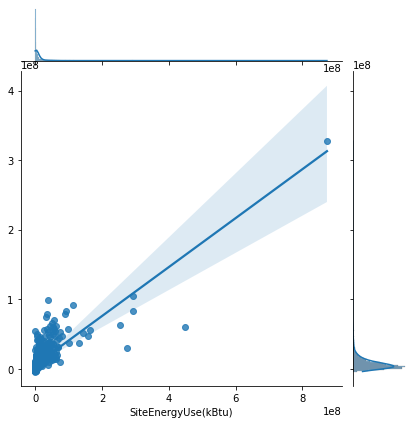

In [35]:
# recherche du meilleur alpha avec GridSearchCV (score r2)
n_alphas = 200
alphas = np.logspace(-2, 5, n_alphas)
model = GridSearchCV(Ridge(), {'alpha': alphas}, scoring=score_list, cv=5, refit='r2', n_jobs=4)
model.fit(df_X, df_y['SiteEnergyUse(kBtu)'])

print(model.best_estimator_)
best_alpha_1 = model.best_params_['alpha']
scores = {k: model.cv_results_[k][model.best_index_] for k, v in model.cv_results_.items() if k.startswith('mean_test_')}
for k, v in scores.items():
    print(f"{k.upper()} -> {abs(v)}")
energy_results_r2['Ridge'] = scores['mean_test_r2']
energy_results_rmse['Ridge'] = abs(scores['mean_test_neg_root_mean_squared_error'])

y_pred = model_selection.cross_val_predict(model.best_estimator_, df_X, df_y['SiteEnergyUse(kBtu)'], cv=5)
_ = sns.jointplot(x = df_y['SiteEnergyUse(kBtu)'], y = y_pred, kind="reg")

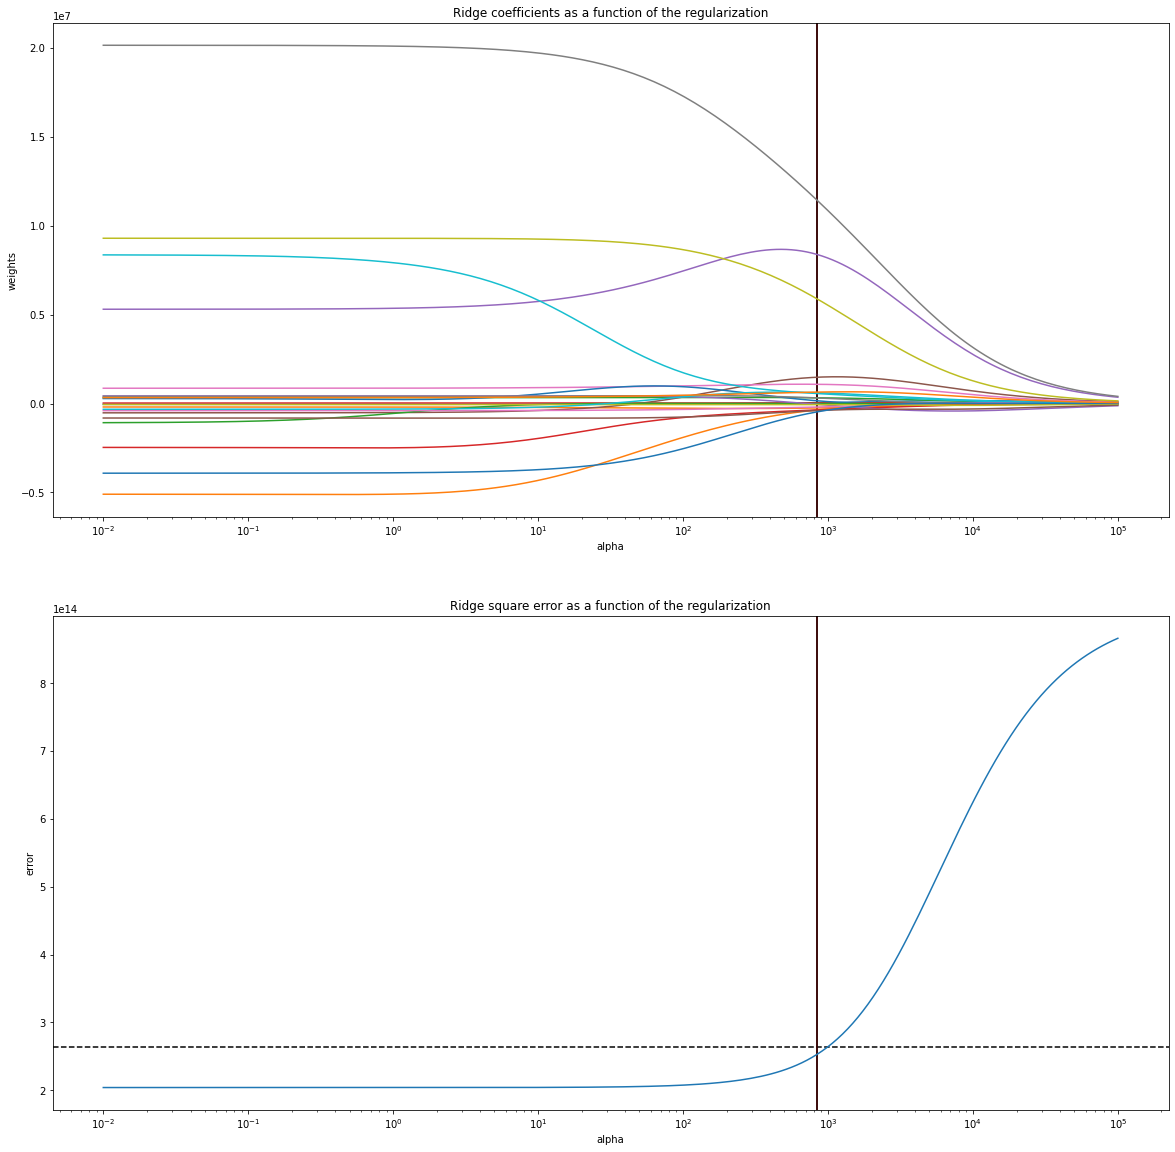

In [36]:
# analyse du modèle rigide
n_alphas = 200
alphas = np.logspace(-2, 5, n_alphas)
model = Ridge()
coefs = []
errors = []
for a in alphas:
    model.set_params(alpha=a)
    model.fit(df_X, df_y['SiteEnergyUse(kBtu)'])
    coefs.append(model.coef_)
    errors.append([np.mean((model.predict(df_X) - df_y['SiteEnergyUse(kBtu)']) ** 2)])

plt.figure(figsize=(20,20))

plt.subplot(211)
plt.axvline(x=best_alpha_1, color='red', label='best_alpha_1')
plt.axvline(x=best_alpha_2, color='black', label='best_alpha_2')

plt.gca()
plt.plot(alphas, coefs)
plt.xscale('log')

plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')

plt.subplot(212)
plt.axhline(y=baseline_error, color='black', linestyle='--')
plt.axvline(x=best_alpha_1, color='red', label='best_alpha_1')
plt.axvline(x=best_alpha_2, color='black', label='best_alpha_2')

plt.gca()
plt.plot(alphas, errors)
plt.xscale('log')

plt.xlabel('alpha')
plt.ylabel('error')
plt.title('Ridge square error as a function of the regularization')
plt.axis('tight')


plt.show()

#### Régression lasso

In [37]:
# cross validation avec un alpha arbitraire (alpha=100)
scores = cross_validate(Lasso(alpha=100), df_X, df_y['SiteEnergyUse(kBtu)'], scoring=score_list, cv=5)
for k, v in scores.items():
    print(f"{k.upper()} -> {statistics.mean(abs(v))}")

FIT_TIME -> 0.0070002079010009766
SCORE_TIME -> 0.002399635314941406
TEST_NEG_MEAN_ABSOLUTE_ERROR -> 6111597.793754667
TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 2954105.604404101
TEST_NEG_MEAN_SQUARED_ERROR -> 263528561313760.88
TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 14852123.263238464
TEST_R2 -> 0.6488036743417654


In [38]:
# recherche du meilleur alpha avec LassoCV
n_alphas = 200
alphas = np.logspace(3, 8, n_alphas)
model = LassoCV(alphas=alphas, cv=5).fit(df_X, df_y['SiteEnergyUse(kBtu)'])
best_alpha_2 = model.alpha_
print(f"Lasso(alpha={best_alpha_2})")

scores = cross_validate(Lasso(alpha=best_alpha_2), df_X, df_y['SiteEnergyUse(kBtu)'], scoring=score_list, cv=5)
for k, v in scores.items():
    print(f"{k.upper()} -> {statistics.mean(abs(v))}")

Lasso(alpha=230043.01197729216)
FIT_TIME -> 0.002601957321166992
SCORE_TIME -> 0.0021982192993164062
TEST_NEG_MEAN_ABSOLUTE_ERROR -> 5839589.482016118
TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 2813524.5293620797
TEST_NEG_MEAN_SQUARED_ERROR -> 258398937599866.9
TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 14551684.488279361
TEST_R2 -> 0.5690221624616058


Lasso(alpha=5542664.520663107)
MEAN_TEST_NEG_MEAN_ABSOLUTE_ERROR -> 5393946.46774058
MEAN_TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 2524256.316734108
MEAN_TEST_NEG_MEAN_SQUARED_ERROR -> 504921341472114.4
MEAN_TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 18758777.35335079
MEAN_TEST_R2 -> 0.4989692079023591


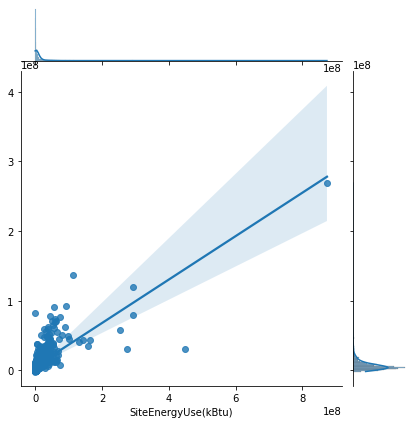

In [39]:
# recherche du meilleur alpha avec GridSearchCV (score r2)
n_alphas = 200
alphas = np.logspace(3, 8, n_alphas)
model = GridSearchCV(Lasso(), {'alpha': alphas}, scoring=score_list, cv=5, refit='r2', n_jobs=4)
model.fit(df_X, df_y['SiteEnergyUse(kBtu)'])

print(model.best_estimator_)
best_alpha_1 = model.best_params_['alpha']
scores = {k: model.cv_results_[k][model.best_index_] for k, v in model.cv_results_.items() if k.startswith('mean_test_')}
for k, v in scores.items():
    print(f"{k.upper()} -> {abs(v)}")
energy_results_r2['Lasso'] = scores['mean_test_r2']
energy_results_rmse['Lasso'] = abs(scores['mean_test_neg_root_mean_squared_error'])

y_pred = model_selection.cross_val_predict(model.best_estimator_, df_X, df_y['SiteEnergyUse(kBtu)'], cv=5)
_ = sns.jointplot(x = df_y['SiteEnergyUse(kBtu)'], y = y_pred, kind="reg")

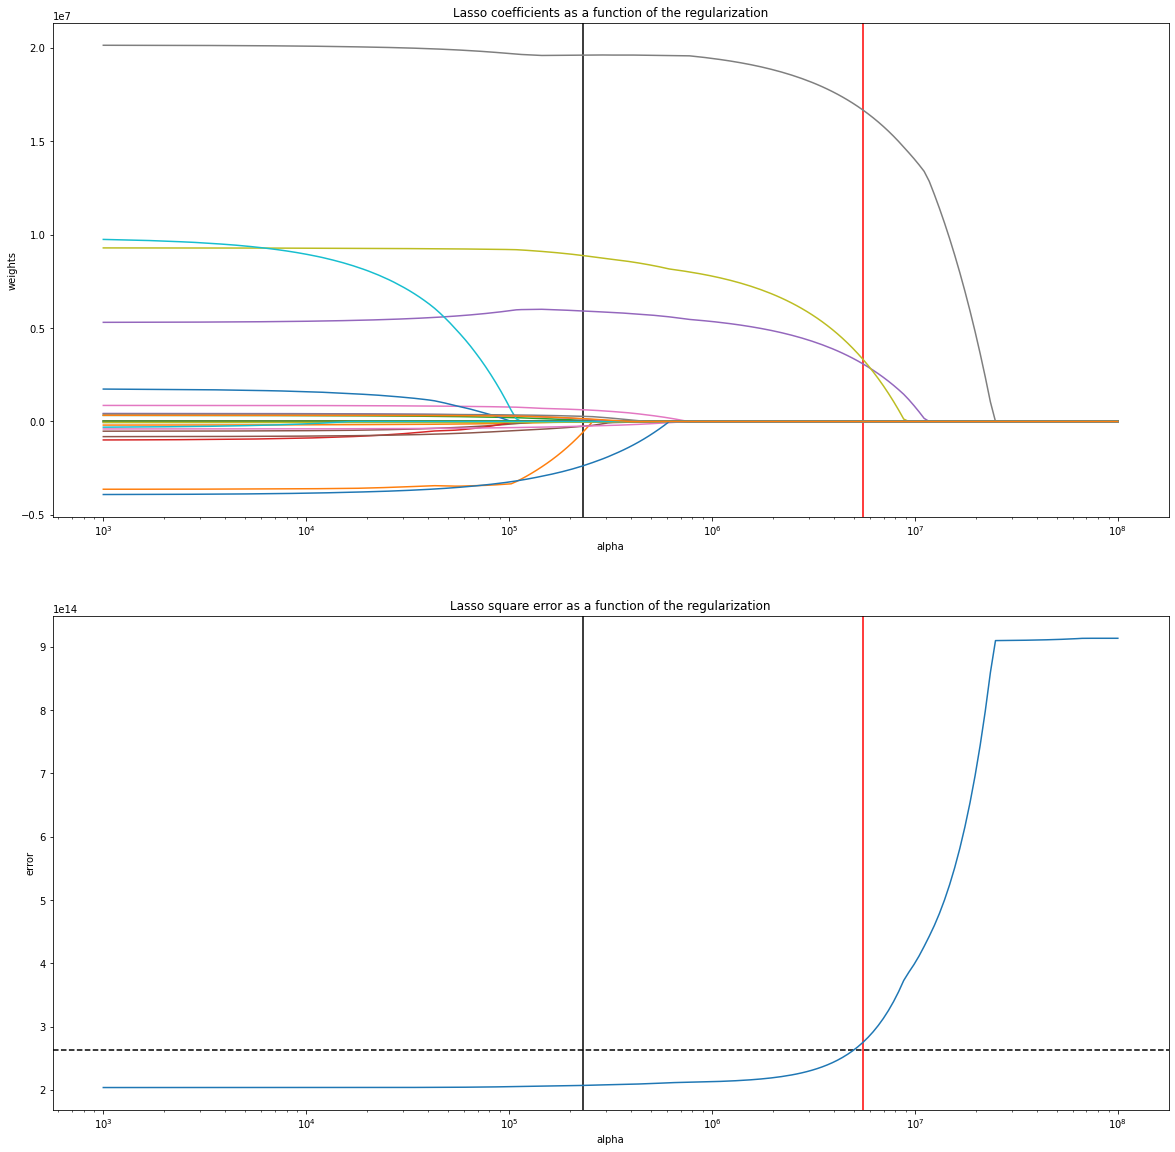

In [40]:
# analyse du modèle lasso
n_alphas = 200
alphas = np.logspace(3, 8, n_alphas)
model = Lasso()
coefs = []
errors = []
for a in alphas:
    model.set_params(alpha=a)
    model.fit(df_X, df_y['SiteEnergyUse(kBtu)'])
    coefs.append(model.coef_)
    errors.append([np.mean((model.predict(df_X) - df_y['SiteEnergyUse(kBtu)']) ** 2)])

plt.figure(figsize=(20,20))

plt.subplot(211)
plt.axvline(x=best_alpha_1, color='red', label ='best_alpha_1')
plt.axvline(x=best_alpha_2, color='black', label ='best_alpha_2')

plt.gca()
plt.plot(alphas, coefs)
plt.xscale('log')

plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')

plt.subplot(212)
plt.axhline(y=baseline_error, color='black', linestyle='--')
plt.axvline(x=best_alpha_1, color='red')
plt.axvline(x=best_alpha_2, color='black')

plt.gca()
plt.plot(alphas, errors)
plt.xscale('log')

plt.xlabel('alpha')
plt.ylabel('error')
plt.title('Lasso square error as a function of the regularization')
plt.axis('tight')

plt.show()

#### Régression ElasticNet

In [41]:
# cross validation avec un alpha arbitraire (alpha=1)
scores = cross_validate(ElasticNet(alpha=1.0), df_X, df_y['SiteEnergyUse(kBtu)'], scoring=score_list, cv=5)
for k, v in scores.items():
    print(f"{k.upper()} -> {statistics.mean(abs(v))}")

FIT_TIME -> 0.0033997535705566407
SCORE_TIME -> 0.0026021957397460937
TEST_NEG_MEAN_ABSOLUTE_ERROR -> 5508160.67633186
TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 2445023.7468366297
TEST_NEG_MEAN_SQUARED_ERROR -> 421852854851001.94
TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 18050478.388958756
TEST_R2 -> 0.4042550769263104


In [42]:
# recherche du meilleur alpha avec ElasticNetCV
n_alphas = 200
alphas = np.logspace(-3, 3, n_alphas)
model = ElasticNetCV(alphas=alphas, cv=5).fit(df_X, df_y['SiteEnergyUse(kBtu)'])
best_alpha_2 = model.alpha_
print(f"ElasticNet(alpha={best_alpha_2})")

scores = cross_validate(ElasticNet(alpha=best_alpha_2), df_X, df_y['SiteEnergyUse(kBtu)'], scoring=score_list, cv=5)
for k, v in scores.items():
    print(f"{k.upper()} -> {statistics.mean(abs(v))}")

ElasticNet(alpha=0.04880251583654431)
FIT_TIME -> 0.004998111724853515
SCORE_TIME -> 0.0027989864349365233
TEST_NEG_MEAN_ABSOLUTE_ERROR -> 5893463.854701762
TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 2877178.5654576956
TEST_NEG_MEAN_SQUARED_ERROR -> 259284965998971.3
TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 14608739.86981941
TEST_R2 -> 0.5791552640997262


ElasticNet(alpha=1.2750512407130128)
MEAN_TEST_NEG_MEAN_ABSOLUTE_ERROR -> 5539771.323192946
MEAN_TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 2471376.118113077
MEAN_TEST_NEG_MEAN_SQUARED_ERROR -> 457564793457182.3
MEAN_TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 18584870.97386359
MEAN_TEST_R2 -> 0.4064635605526397


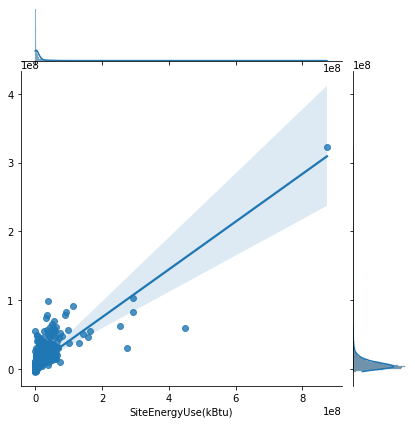

In [43]:
# recherche du meilleur alpha avec GridSearchCV (score r2)
n_alphas = 200
alphas = np.logspace(-3, 3, n_alphas)
model = GridSearchCV(ElasticNet(), {'alpha': alphas}, scoring=score_list, cv=5, refit='r2', n_jobs=4)
model.fit(df_X, df_y['SiteEnergyUse(kBtu)'])

print(model.best_estimator_)
best_alpha_1 = model.best_params_['alpha']
scores = {k: model.cv_results_[k][model.best_index_] for k, v in model.cv_results_.items() if k.startswith('mean_test_')}
for k, v in scores.items():
    print(f"{k.upper()} -> {abs(v)}")
energy_results_r2['ElasticNet'] = scores['mean_test_r2']
energy_results_rmse['ElasticNet'] = abs(scores['mean_test_neg_root_mean_squared_error'])

y_pred = model_selection.cross_val_predict(model.best_estimator_, df_X, df_y['SiteEnergyUse(kBtu)'], cv=5)
_ = sns.jointplot(x = df_y['SiteEnergyUse(kBtu)'], y = y_pred, kind="reg")

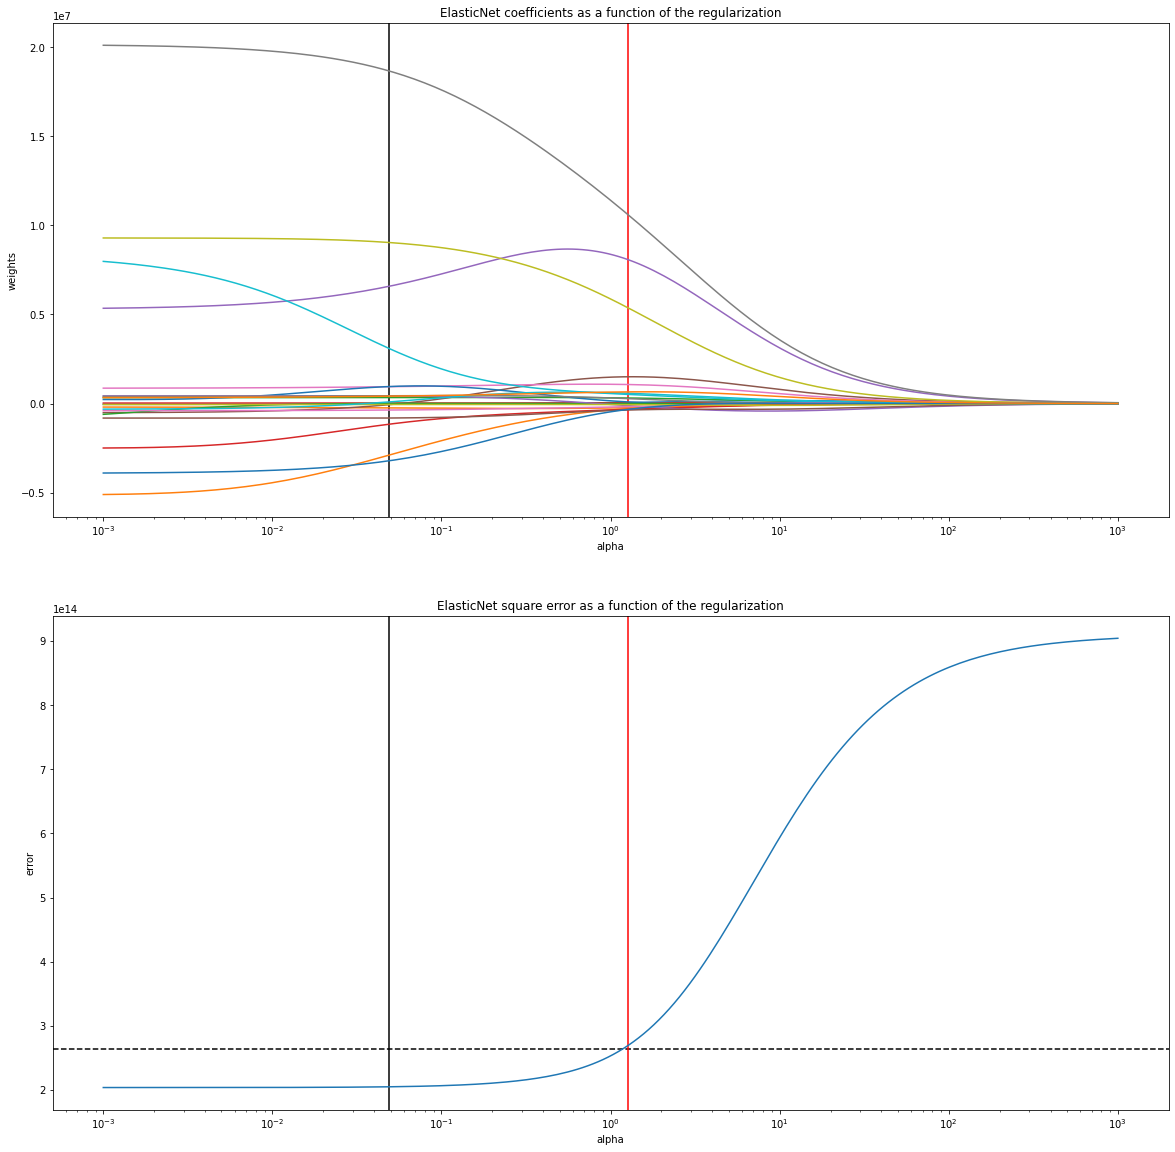

In [44]:
# analyse du modèle elastic
n_alphas = 200
alphas = np.logspace(-3, 3, n_alphas)
model = ElasticNet()
coefs = []
errors = []
for a in alphas:
    model.set_params(alpha=a)
    model.fit(df_X, df_y['SiteEnergyUse(kBtu)'])
    coefs.append(model.coef_)
    errors.append([np.mean((model.predict(df_X) - df_y['SiteEnergyUse(kBtu)']) ** 2)])

plt.figure(figsize=(20,20))

plt.subplot(211)
plt.axvline(x=best_alpha_1, color='red', label ='best_alpha_1')
plt.axvline(x=best_alpha_2, color='black', label ='best_alpha_2')

plt.gca()
plt.plot(alphas, coefs)
plt.xscale('log')

plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('ElasticNet coefficients as a function of the regularization')
plt.axis('tight')

plt.subplot(212)
plt.axhline(y=baseline_error, color='black', linestyle='--')
plt.axvline(x=best_alpha_1, color='red')
plt.axvline(x=best_alpha_2, color='black')

plt.gca()
plt.plot(alphas, errors)
plt.xscale('log')

plt.xlabel('alpha')
plt.ylabel('error')
plt.title('ElasticNet square error as a function of the regularization')
plt.axis('tight')

plt.show()

### Analyse des modèles en arbre de décision (SiteEnergyUse(kBtu))

#### Modèle RandomForest

In [45]:
# cross validation avec les paramètres par défaut
scores = cross_validate(RandomForestRegressor(), df_X, df_y['SiteEnergyUse(kBtu)'], scoring=score_list, cv=5)
for k, v in scores.items():
    print(f"{k.upper()} -> {statistics.mean(abs(v))}")

FIT_TIME -> 0.7089936256408691
SCORE_TIME -> 0.012407732009887696
TEST_NEG_MEAN_ABSOLUTE_ERROR -> 3772325.3685876965
TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 1054849.6505009984
TEST_NEG_MEAN_SQUARED_ERROR -> 540582596442552.1
TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 18821451.646073524
TEST_R2 -> 0.44302470978170905


RandomForestRegressor(max_depth=6, max_samples=0.5, n_jobs=4)
{'max_depth': 6, 'max_features': 'auto', 'max_samples': 0.5, 'n_estimators': 100, 'n_jobs': 4}
MEAN_TEST_NEG_MEAN_ABSOLUTE_ERROR -> 4107737.2574940473
MEAN_TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 1468796.6520836824
MEAN_TEST_NEG_MEAN_SQUARED_ERROR -> 533594570945175.9
MEAN_TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 18664205.723154344
MEAN_TEST_R2 -> 0.47457579553508233


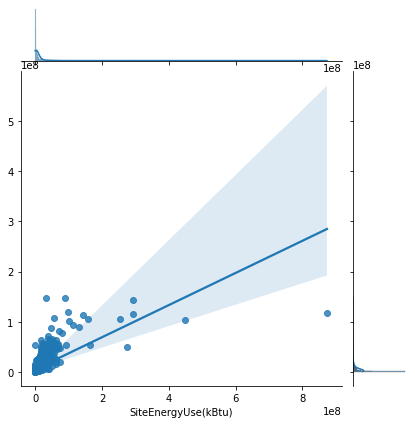

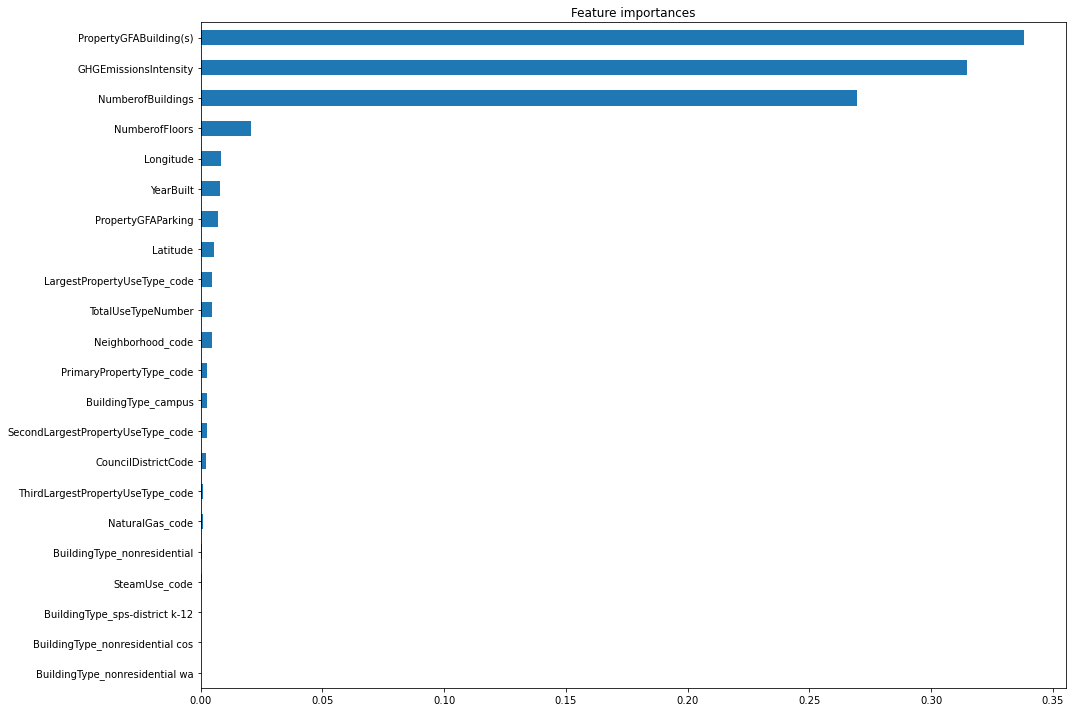

In [46]:
# recherche du meilleur paramètre avec GridSearchCV (score r2)
parameters = {
    'n_estimators': [100, 400, 700],
    'max_depth': [1, 2, 3, 4, 5, 6],
    'max_samples': [0.5, 1],
    'max_features': ['auto', 'sqrt'],
    'n_jobs': [4]
}

model = GridSearchCV(RandomForestRegressor(), parameters, scoring=score_list, cv=5, refit='r2', n_jobs=4)
model.fit(df_X, df_y['SiteEnergyUse(kBtu)'])

print(model.best_estimator_)
print(model.best_params_)
scores = {k: model.cv_results_[k][model.best_index_] for k, v in model.cv_results_.items() if k.startswith('mean_test_')}
for k, v in scores.items():
    print(f"{k.upper()} -> {abs(v)}")
energy_results_r2['RandomForestRegressor'] = scores['mean_test_r2']
energy_results_rmse['RandomForestRegressor'] = abs(scores['mean_test_neg_root_mean_squared_error'])

y_pred = model_selection.cross_val_predict(model.best_estimator_, df_X, df_y['SiteEnergyUse(kBtu)'], cv=5)
_ = sns.jointplot(x = df_y['SiteEnergyUse(kBtu)'], y = y_pred, kind="reg")

energy_forest_feature_importance = pd.Series(model.best_estimator_.feature_importances_, index=df_X.columns).sort_values()
fig, ax = plt.subplots()
energy_forest_feature_importance.plot.barh(ax=ax)
ax.set_title("Feature importances")
fig.set_size_inches(15,10)
fig.tight_layout()

#### Modèle XGBoost

In [47]:
# cross validation avec les paramètres par défaut
scores = cross_validate(XGBRegressor(), df_X, df_y['SiteEnergyUse(kBtu)'], scoring=score_list, cv=5)
for k, v in scores.items():
    print(f"{k.upper()} -> {statistics.mean(abs(v))}")

FIT_TIME -> 0.34999961853027345
SCORE_TIME -> 0.006000041961669922
TEST_NEG_MEAN_ABSOLUTE_ERROR -> 3994342.4231425463
TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 971298.53125
TEST_NEG_MEAN_SQUARED_ERROR -> 577772966009911.1
TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 20619567.802662127
TEST_R2 -> 0.9877241389158271


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.03, max_delta_step=0,
             max_depth=5, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4, nthread=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.3,
             tree_method='exact', validate_parameters=1, verbosity=None)
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'nthread': 4, 'objective': 'reg:squarederror', 'subsample': 0.3}
MEAN_TEST_NEG_MEAN_ABSOLUTE_ERROR -> 4093469.6585608525
MEAN_TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 1225333.725
MEAN_TEST_NEG_MEAN_SQUARED_ERROR -> 554689199980884.6
MEAN_TEST_NEG_ROOT_MEAN_SQUA

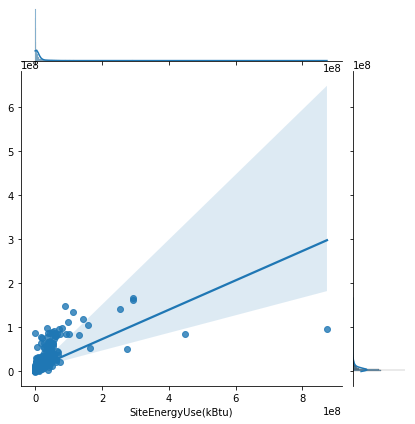

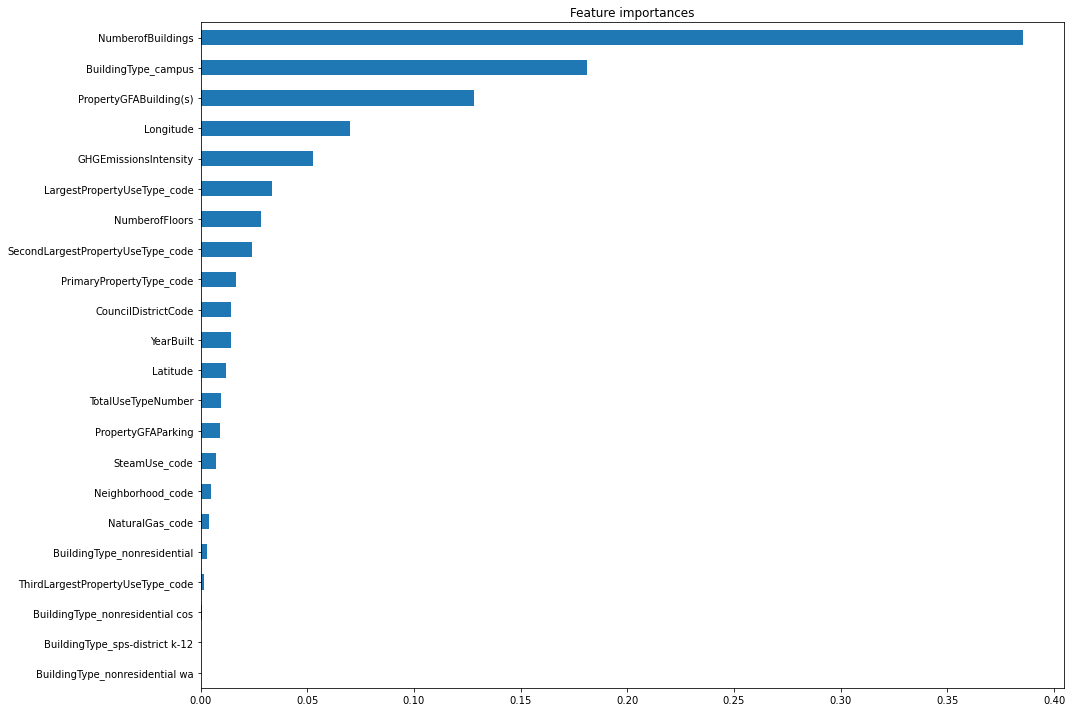

In [48]:
# recherche du meilleur paramètre avec GridSearchCV (score r2)
parameters = {
    'nthread':[4],
    'objective':['reg:squarederror'],
    'learning_rate': [0.03, 0.05, 0.07],
    'max_depth': [5, 6, 7],
    'min_child_weight': [4],
    'subsample': [0.3, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.5, 0.7],
    'n_estimators': [100, 400, 700]
}

model = GridSearchCV(XGBRegressor(), parameters, scoring=score_list, cv=5, refit='r2', n_jobs=4)
model.fit(df_X, df_y['SiteEnergyUse(kBtu)'])

print(model.best_estimator_)
print(model.best_params_)
scores = {k: model.cv_results_[k][model.best_index_] for k, v in model.cv_results_.items() if k.startswith('mean_test_')}
for k, v in scores.items():
    print(f"{k.upper()} -> {abs(v)}")
energy_results_r2['XGBRegressor'] = scores['mean_test_r2']
energy_results_rmse['XGBRegressor'] = abs(scores['mean_test_neg_root_mean_squared_error'])

y_pred = model_selection.cross_val_predict(model.best_estimator_, df_X, df_y['SiteEnergyUse(kBtu)'], cv=5)
_ = sns.jointplot(x = df_y['SiteEnergyUse(kBtu)'], y = y_pred, kind="reg")

energy_xgboost_feature_importance = pd.Series(model.best_estimator_.feature_importances_, index=df_X.columns).sort_values()
fig, ax = plt.subplots()
energy_xgboost_feature_importance.plot.barh(ax=ax)
ax.set_title("Feature importances")
fig.set_size_inches(15,10)
fig.tight_layout()

### Analyse des modèles linéaires (TotalGHGEmissions)

#### Régression linéaire

FIT_TIME -> 0.002800130844116211
SCORE_TIME -> 0.0019998073577880858
TEST_NEG_MEAN_ABSOLUTE_ERROR -> 218.23028334534948
TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 104.35881097554467
TEST_NEG_MEAN_SQUARED_ERROR -> 498669.2250627886
TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 649.0509792423742
TEST_R2 -> 0.9228656293754617


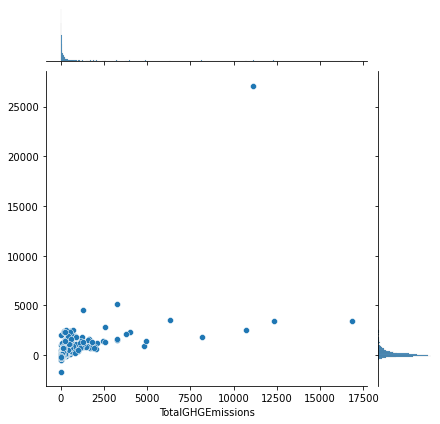

In [49]:
# regression lineaire avec cross validation (5 shards)
scores = cross_validate(LinearRegression(), df_X, df_y['TotalGHGEmissions'], scoring=score_list, cv=5)
for k, v in scores.items():
    print(f"{k.upper()} -> {statistics.mean(abs(v))}")
baseline_error = statistics.mean(abs(scores['test_neg_mean_squared_error']))
emission_results_r2['LinearRegression'] = statistics.mean(scores['test_r2'])
emission_results_rmse['LinearRegression'] = statistics.mean(abs(scores['test_neg_root_mean_squared_error']))

y_pred = model_selection.cross_val_predict(LinearRegression(), df_X, df_y['TotalGHGEmissions'], cv=5)
_ = sns.jointplot(x = df_y['TotalGHGEmissions'], y = y_pred)

#### Régression rigide

In [50]:
# cross validation avec un alpha arbitraire (alpha=1)
scores = cross_validate(Ridge(alpha=1.0), df_X, df_y['TotalGHGEmissions'], scoring=score_list, cv=5)
for k, v in scores.items():
    print(f"{k.upper()} -> {statistics.mean(abs(v))}")

FIT_TIME -> 0.0024038314819335937
SCORE_TIME -> 0.0019959926605224608
TEST_NEG_MEAN_ABSOLUTE_ERROR -> 217.68077834240523
TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 104.1258412979113
TEST_NEG_MEAN_SQUARED_ERROR -> 498308.3542797274
TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 648.4616608463693
TEST_R2 -> 0.9084267156586519


In [51]:
# recherche du meilleur alpha avec RidgeCV
n_alphas = 200
alphas = np.logspace(0, 7, n_alphas)
model = RidgeCV(alphas=alphas, cv=5).fit(df_X, df_y['TotalGHGEmissions'])
best_alpha_2 = model.alpha_
print(f"Ridge(alpha={best_alpha_2})")

scores = cross_validate(Ridge(alpha=best_alpha_2), df_X, df_y['TotalGHGEmissions'], scoring=score_list, cv=5)
for k, v in scores.items():
    print(f"{k.upper()} -> {statistics.mean(abs(v))}")

Ridge(alpha=1464.9713983072863)
FIT_TIME -> 0.0019994735717773437
SCORE_TIME -> 0.0020011425018310546
TEST_NEG_MEAN_ABSOLUTE_ERROR -> 159.65942567646024
TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 76.25205481772277
TEST_NEG_MEAN_SQUARED_ERROR -> 392734.27232087887
TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 527.5934708199616
TEST_R2 -> 0.3129600841848925


Ridge(alpha=1464.9713983072863)
MEAN_TEST_NEG_MEAN_ABSOLUTE_ERROR -> 159.6594256764602
MEAN_TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 76.2520548177229
MEAN_TEST_NEG_MEAN_SQUARED_ERROR -> 392734.2723208788
MEAN_TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 527.5934708199615
MEAN_TEST_R2 -> 0.31296008418489263


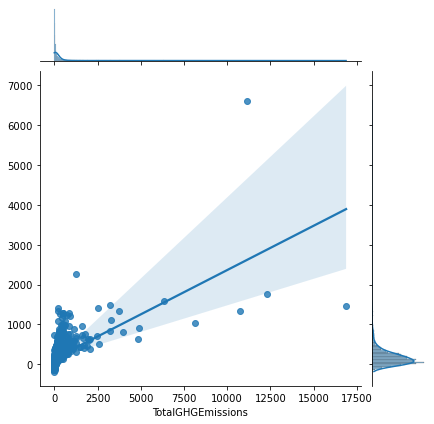

In [52]:
# recherche du meilleur alpha avec GridSearchCV (score r2)
n_alphas = 200
alphas = np.logspace(0, 7, n_alphas)
model = GridSearchCV(Ridge(), {'alpha': alphas}, scoring=score_list, cv=5, refit='r2', n_jobs=4)
model.fit(df_X, df_y['TotalGHGEmissions'])

print(model.best_estimator_)
best_alpha_1 = model.best_params_['alpha']
scores = {k: model.cv_results_[k][model.best_index_] for k, v in model.cv_results_.items() if k.startswith('mean_test_')}
for k, v in scores.items():
    print(f"{k.upper()} -> {abs(v)}")
emission_results_r2['Ridge'] = scores['mean_test_r2']
emission_results_rmse['Ridge'] = abs(scores['mean_test_neg_root_mean_squared_error'])

y_pred = model_selection.cross_val_predict(model.best_estimator_, df_X, df_y['TotalGHGEmissions'], cv=5)
_ = sns.jointplot(x = df_y['TotalGHGEmissions'], y = y_pred, kind="reg")

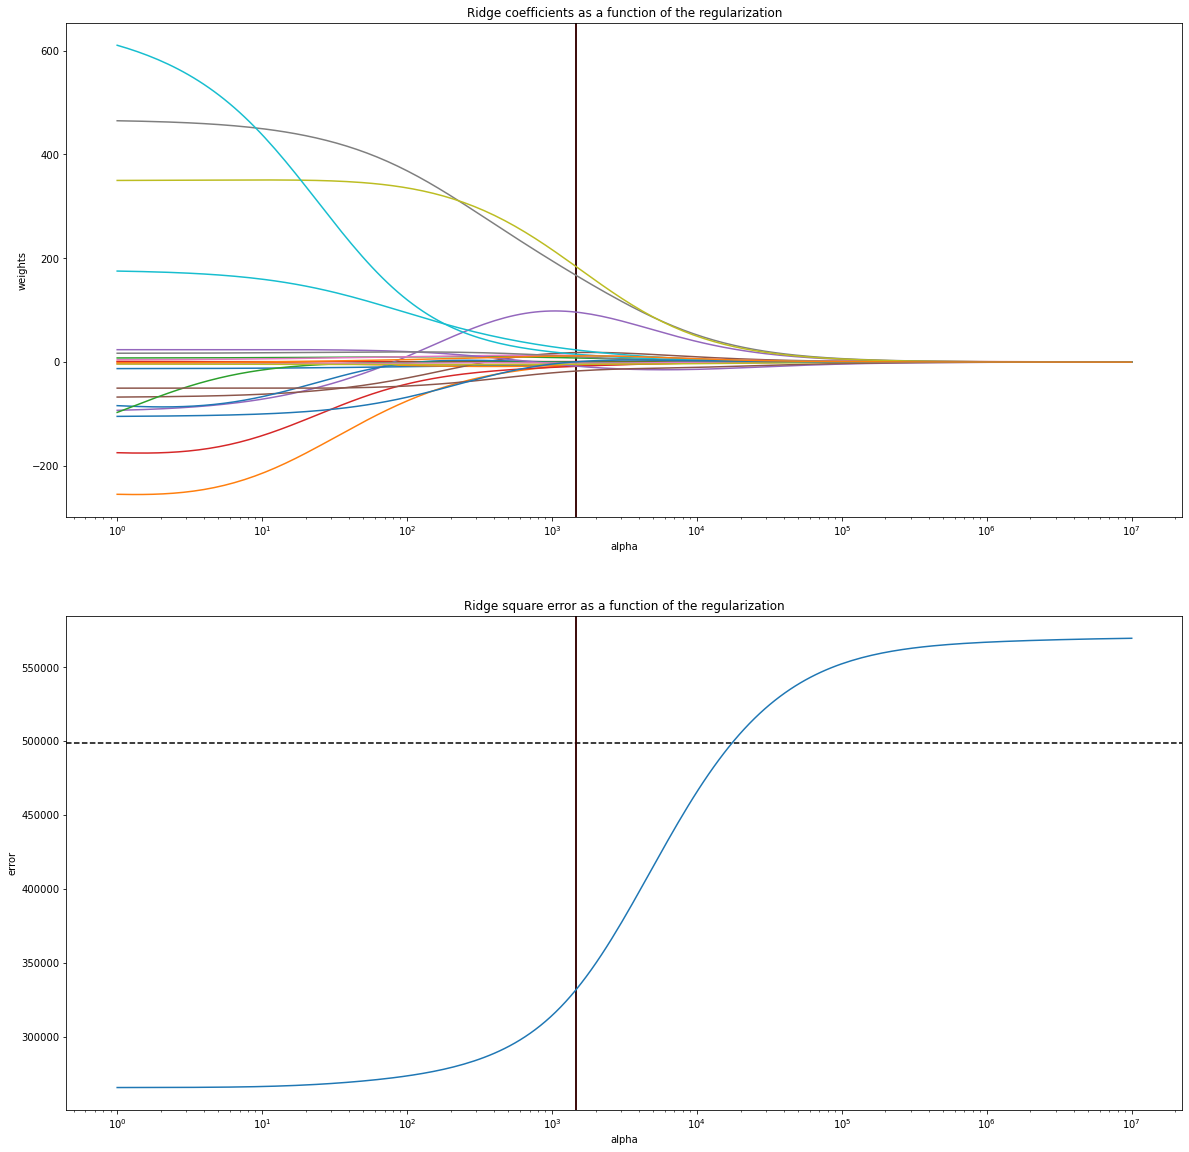

In [53]:
# analyse du modèle rigide
n_alphas = 200
alphas = np.logspace(0, 7, n_alphas)
model = Ridge()
coefs = []
errors = []
for a in alphas:
    model.set_params(alpha=a)
    model.fit(df_X, df_y['TotalGHGEmissions'])
    coefs.append(model.coef_)
    errors.append([np.mean((model.predict(df_X) - df_y['TotalGHGEmissions']) ** 2)])

plt.figure(figsize=(20,20))

plt.subplot(211)
plt.axvline(x=best_alpha_1, color='red', label='best_alpha_1')
plt.axvline(x=best_alpha_2, color='black', label='best_alpha_2')

plt.gca()
plt.plot(alphas, coefs)
plt.xscale('log')

plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')

plt.subplot(212)
plt.axhline(y=baseline_error, color='black', linestyle='--')
plt.axvline(x=best_alpha_1, color='red', label='best_alpha_1')
plt.axvline(x=best_alpha_2, color='black', label='best_alpha_2')

plt.gca()
plt.plot(alphas, errors)
plt.xscale('log')

plt.xlabel('alpha')
plt.ylabel('error')
plt.title('Ridge square error as a function of the regularization')
plt.axis('tight')


plt.show()

#### Régression lasso

In [54]:
# cross validation avec un alpha arbitraire (alpha=1)
scores = cross_validate(Lasso(alpha=1.0), df_X, df_y['TotalGHGEmissions'], scoring=score_list, cv=5)
for k, v in scores.items():
    print(f"{k.upper()} -> {statistics.mean(abs(v))}")

FIT_TIME -> 0.0038000106811523437
SCORE_TIME -> 0.0021999359130859377
TEST_NEG_MEAN_ABSOLUTE_ERROR -> 215.61899060755124
TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 102.0535881535975
TEST_NEG_MEAN_SQUARED_ERROR -> 501618.66748487705
TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 649.4918170410334
TEST_R2 -> 0.8904109799331276


In [55]:
# recherche du meilleur alpha avec LassoCV
n_alphas = 200
alphas = np.logspace(-1, 4, n_alphas)
model = LassoCV(alphas=alphas, cv=5).fit(df_X, df_y['TotalGHGEmissions'])
best_alpha_2 = model.alpha_
print(f"Lasso(alpha={best_alpha_2})")

scores = cross_validate(Lasso(alpha=best_alpha_2), df_X, df_y['TotalGHGEmissions'], scoring=score_list, cv=5)
for k, v in scores.items():
    print(f"{k.upper()} -> {statistics.mean(abs(v))}")

Lasso(alpha=54.78901179593945)
FIT_TIME -> 0.0030001163482666015
SCORE_TIME -> 0.0025995731353759765
TEST_NEG_MEAN_ABSOLUTE_ERROR -> 175.99394145480014
TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 80.21422078434688
TEST_NEG_MEAN_SQUARED_ERROR -> 362725.5288420787
TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 526.7511375824248
TEST_R2 -> 0.5650663945657561


Lasso(alpha=164.46761779946644)
MEAN_TEST_NEG_MEAN_ABSOLUTE_ERROR -> 160.95747629914936
MEAN_TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 60.4850708772129
MEAN_TEST_NEG_MEAN_SQUARED_ERROR -> 435764.43915157707
MEAN_TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 558.9329744018336
MEAN_TEST_R2 -> 0.23785605602524718


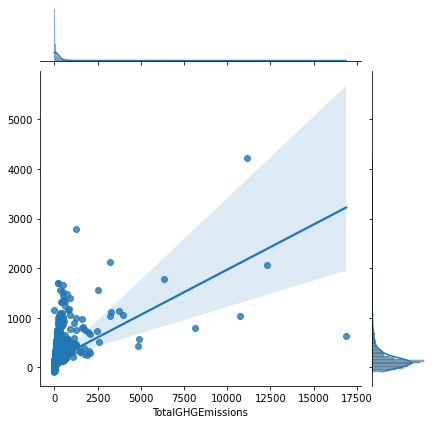

In [56]:
# recherche du meilleur alpha avec GridSearchCV (score r2)
n_alphas = 200
alphas = np.logspace(-1, 4, n_alphas)
model = GridSearchCV(Lasso(), {'alpha': alphas}, scoring=score_list, cv=5, refit='r2', n_jobs=4)
model.fit(df_X, df_y['TotalGHGEmissions'])

print(model.best_estimator_)
best_alpha_1 = model.best_params_['alpha']
scores = {k: model.cv_results_[k][model.best_index_] for k, v in model.cv_results_.items() if k.startswith('mean_test_')}
for k, v in scores.items():
    print(f"{k.upper()} -> {abs(v)}")
emission_results_r2['Lasso'] = scores['mean_test_r2']
emission_results_rmse['Lasso'] = abs(scores['mean_test_neg_root_mean_squared_error'])

y_pred = model_selection.cross_val_predict(model.best_estimator_, df_X, df_y['TotalGHGEmissions'], cv=5)
_ = sns.jointplot(x = df_y['TotalGHGEmissions'], y = y_pred, kind="reg")

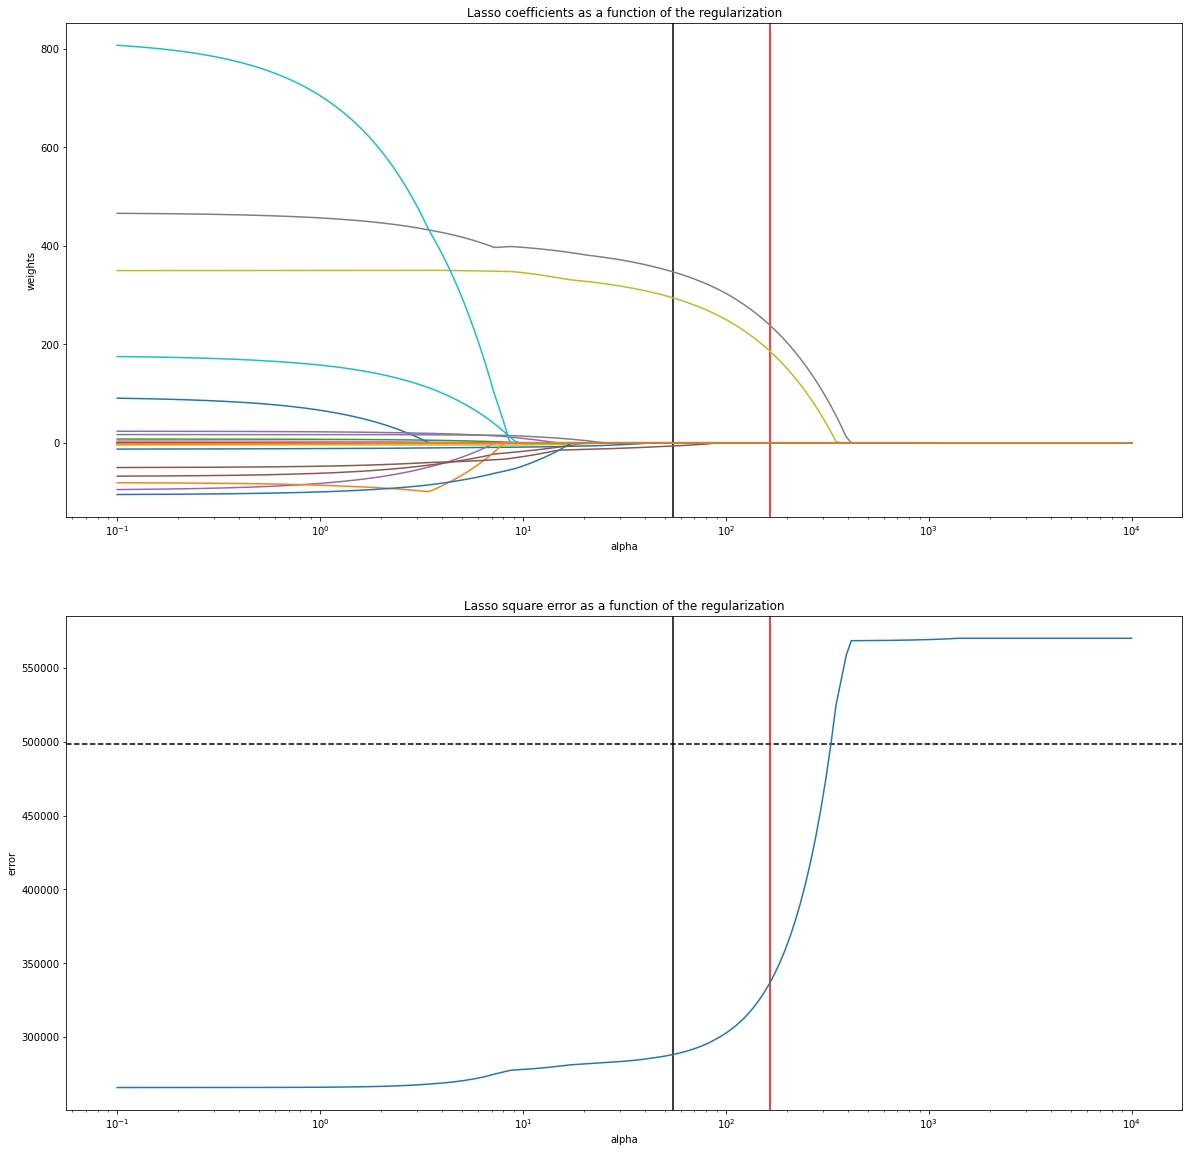

In [57]:
# analyse du modèle lasso
n_alphas = 200
alphas = np.logspace(-1, 4, n_alphas)
model = Lasso()
coefs = []
errors = []
for a in alphas:
    model.set_params(alpha=a)
    model.fit(df_X, df_y['TotalGHGEmissions'])
    coefs.append(model.coef_)
    errors.append([np.mean((model.predict(df_X) - df_y['TotalGHGEmissions']) ** 2)])

plt.figure(figsize=(20,20))

plt.subplot(211)
plt.axvline(x=best_alpha_1, color='red', label ='best_alpha_1')
plt.axvline(x=best_alpha_2, color='black', label ='best_alpha_2')

plt.gca()
plt.plot(alphas, coefs)
plt.xscale('log')

plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')

plt.subplot(212)
plt.axhline(y=baseline_error, color='black', linestyle='--')
plt.axvline(x=best_alpha_1, color='red')
plt.axvline(x=best_alpha_2, color='black')

plt.gca()
plt.plot(alphas, errors)
plt.xscale('log')

plt.xlabel('alpha')
plt.ylabel('error')
plt.title('Lasso square error as a function of the regularization')
plt.axis('tight')

plt.show()

#### Régression ElasticNet

In [58]:
# cross validation avec un alpha arbitraire (alpha=1)
scores = cross_validate(ElasticNet(alpha=1.0), df_X, df_y['TotalGHGEmissions'], scoring=score_list, cv=5)
for k, v in scores.items():
    print(f"{k.upper()} -> {statistics.mean(abs(v))}")

FIT_TIME -> 0.002998638153076172
SCORE_TIME -> 0.0026003360748291016
TEST_NEG_MEAN_ABSOLUTE_ERROR -> 162.5467683967332
TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 74.12900440603686
TEST_NEG_MEAN_SQUARED_ERROR -> 361522.06431712175
TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 509.94528329174403
TEST_R2 -> 0.41964768553692905


In [59]:
# recherche du meilleur alpha avec ElasticNetCV
n_alphas = 200
alphas = np.logspace(-3, 3, n_alphas)
model = ElasticNetCV(alphas=alphas, cv=5).fit(df_X, df_y['TotalGHGEmissions'])
best_alpha_2 = model.alpha_
print(f"ElasticNet(alpha={best_alpha_2})")

scores = cross_validate(ElasticNet(alpha=best_alpha_2), df_X, df_y['TotalGHGEmissions'], scoring=score_list, cv=5)
for k, v in scores.items():
    print(f"{k.upper()} -> {statistics.mean(abs(v))}")

ElasticNet(alpha=0.7316807143427192)
FIT_TIME -> 0.0029929637908935546
SCORE_TIME -> 0.0022011756896972655
TEST_NEG_MEAN_ABSOLUTE_ERROR -> 167.528882973805
TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 75.23279257758297
TEST_NEG_MEAN_SQUARED_ERROR -> 358427.9844496779
TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 514.3668382307128
TEST_R2 -> 0.466381147824319


ElasticNet(alpha=2.2219468609395236)
MEAN_TEST_NEG_MEAN_ABSOLUTE_ERROR -> 159.56183027670517
MEAN_TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 75.51640558248309
MEAN_TEST_NEG_MEAN_SQUARED_ERROR -> 394959.39059454546
MEAN_TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 529.1309844866018
MEAN_TEST_R2 -> 0.31306123454282747


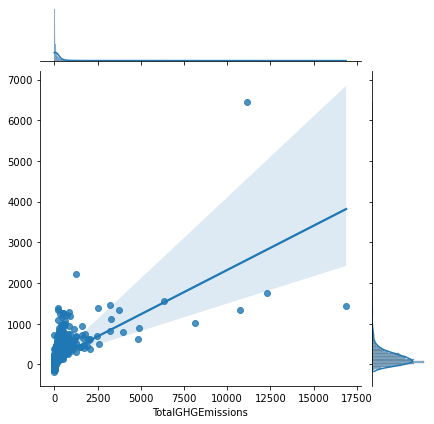

In [60]:
# recherche du meilleur alpha avec GridSearchCV (score r2)
n_alphas = 200
alphas = np.logspace(-3, 3, n_alphas)
model = GridSearchCV(ElasticNet(), {'alpha': alphas}, scoring=score_list, cv=5, refit='r2', n_jobs=4)
model.fit(df_X, df_y['TotalGHGEmissions'])

print(model.best_estimator_)
best_alpha_1 = model.best_params_['alpha']
scores = {k: model.cv_results_[k][model.best_index_] for k, v in model.cv_results_.items() if k.startswith('mean_test_')}
for k, v in scores.items():
    print(f"{k.upper()} -> {abs(v)}")
emission_results_r2['ElasticNet'] = scores['mean_test_r2']
emission_results_rmse['ElasticNet'] = abs(scores['mean_test_neg_root_mean_squared_error'])

y_pred = model_selection.cross_val_predict(model.best_estimator_, df_X, df_y['TotalGHGEmissions'], cv=5)
_ = sns.jointplot(x = df_y['TotalGHGEmissions'], y = y_pred, kind="reg")

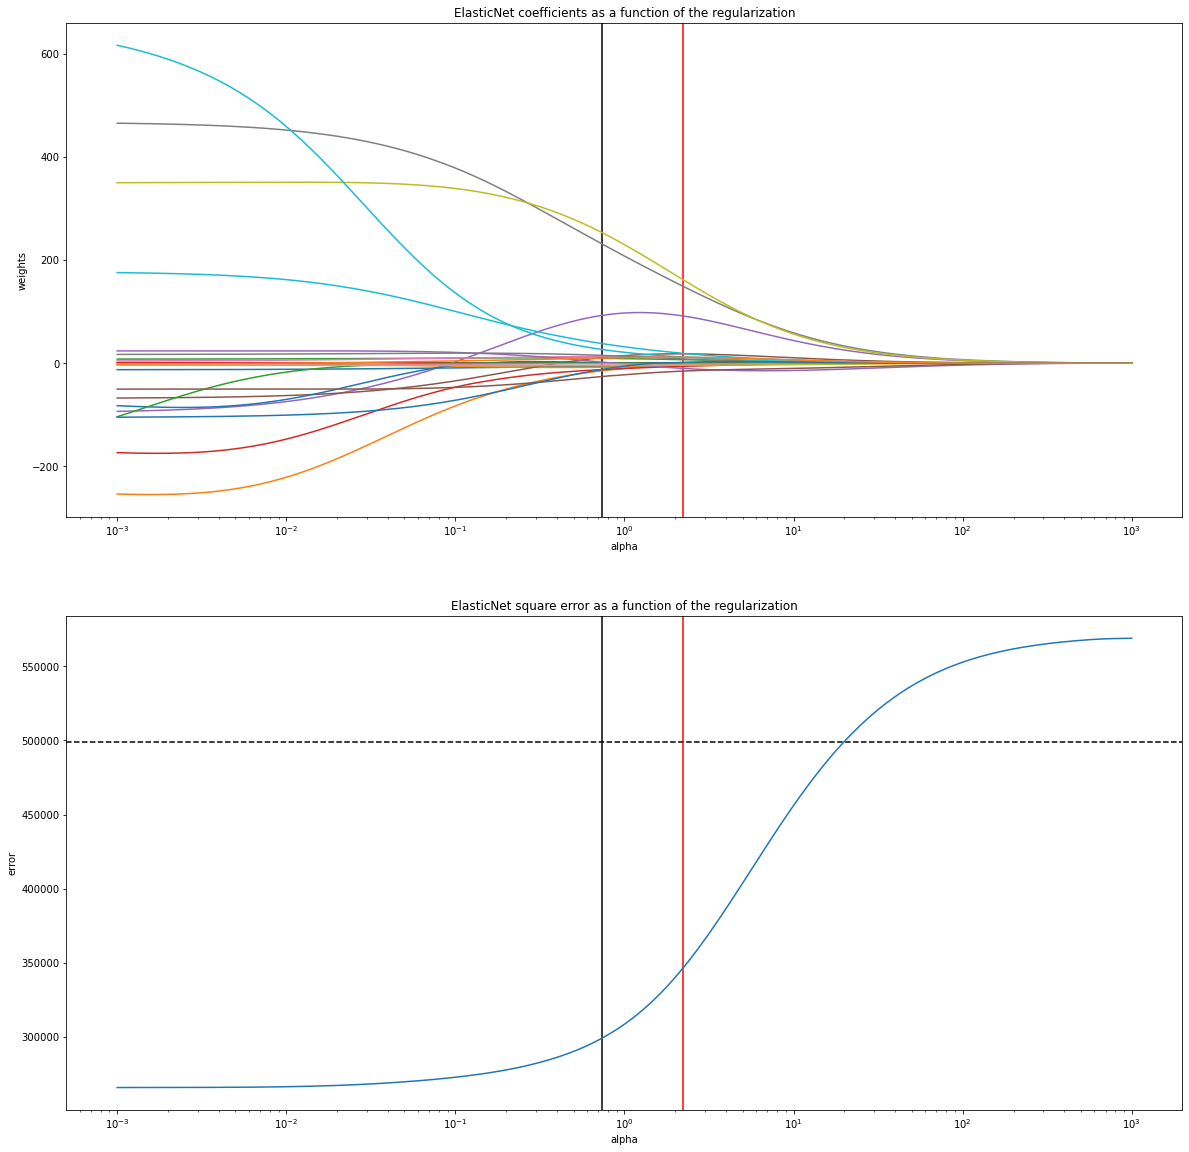

In [61]:
# analyse du modèle elastic
n_alphas = 200
alphas = np.logspace(-3, 3, n_alphas)
model = ElasticNet()
coefs = []
errors = []
for a in alphas:
    model.set_params(alpha=a)
    model.fit(df_X, df_y['TotalGHGEmissions'])
    coefs.append(model.coef_)
    errors.append([np.mean((model.predict(df_X) - df_y['TotalGHGEmissions']) ** 2)])

plt.figure(figsize=(20,20))

plt.subplot(211)
plt.axvline(x=best_alpha_1, color='red', label ='best_alpha_1')
plt.axvline(x=best_alpha_2, color='black', label ='best_alpha_2')

plt.gca()
plt.plot(alphas, coefs)
plt.xscale('log')

plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('ElasticNet coefficients as a function of the regularization')
plt.axis('tight')

plt.subplot(212)
plt.axhline(y=baseline_error, color='black', linestyle='--')
plt.axvline(x=best_alpha_1, color='red')
plt.axvline(x=best_alpha_2, color='black')

plt.gca()
plt.plot(alphas, errors)
plt.xscale('log')

plt.xlabel('alpha')
plt.ylabel('error')
plt.title('ElasticNet square error as a function of the regularization')
plt.axis('tight')

plt.show()

### Analyse des modèles en arbre de décision (TotalGHGEmissions)

#### Modèle RandomForest

In [62]:
# cross validation avec les paramètres par défaut
scores = cross_validate(RandomForestRegressor(), df_X, df_y['TotalGHGEmissions'], scoring=score_list, cv=5)
for k, v in scores.items():
    print(f"{k.upper()} -> {statistics.mean(abs(v))}")

FIT_TIME -> 0.6676024913787841
SCORE_TIME -> 0.011800718307495118
TEST_NEG_MEAN_ABSOLUTE_ERROR -> 58.40006548672568
TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 5.799400000000007
TEST_NEG_MEAN_SQUARED_ERROR -> 262251.51772309036
TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 442.90612483787925
TEST_R2 -> 1.820179017324207


RandomForestRegressor(max_depth=6, max_features='sqrt', max_samples=0.5,
                      n_estimators=700, n_jobs=4)
{'max_depth': 6, 'max_features': 'sqrt', 'max_samples': 0.5, 'n_estimators': 700, 'n_jobs': 4}
MEAN_TEST_NEG_MEAN_ABSOLUTE_ERROR -> 125.86380387634703
MEAN_TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 49.82120658211106
MEAN_TEST_NEG_MEAN_SQUARED_ERROR -> 333573.20108332485
MEAN_TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 473.50652820124685
MEAN_TEST_R2 -> 0.5289814602043486


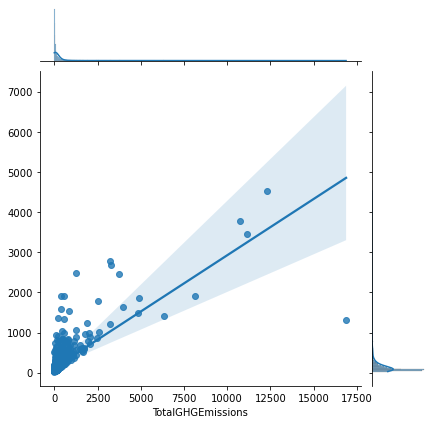

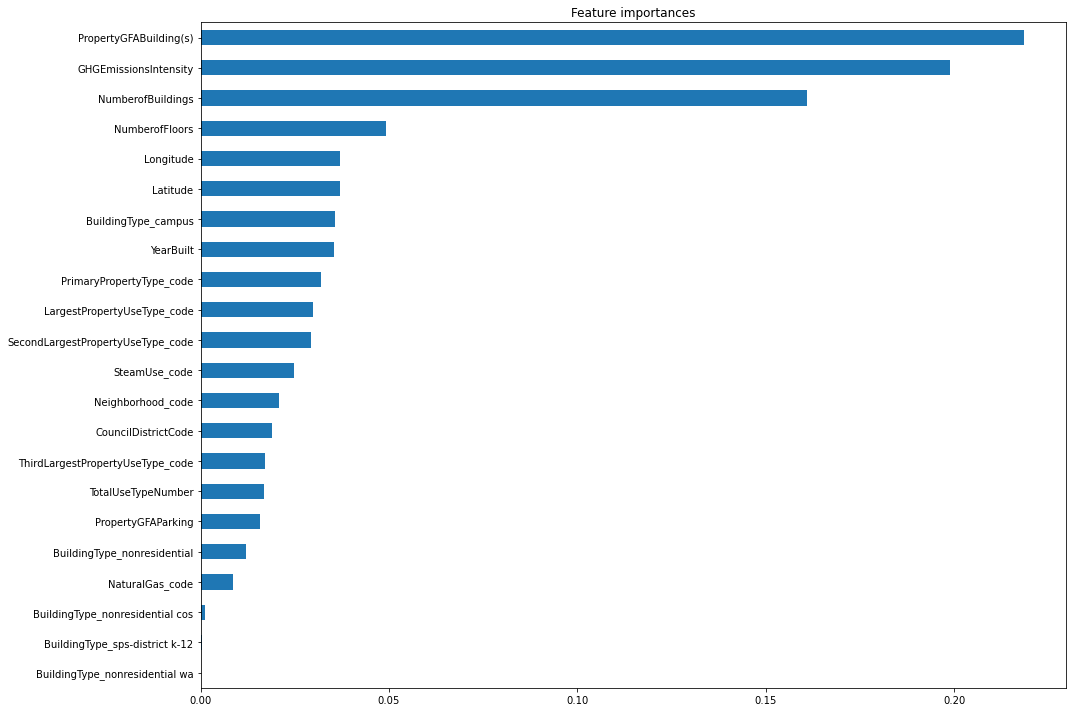

In [63]:
# recherche du meilleur paramètre avec GridSearchCV (score r2)
parameters = {
    'n_estimators': [100, 400, 700],
    'max_depth': [1, 2, 3, 4, 5, 6],
    'max_samples': [0.5, 1],
    'max_features': ['auto', 'sqrt'],
    'n_jobs': [4]
}

model = GridSearchCV(RandomForestRegressor(), parameters, scoring=score_list, cv=5, refit='r2', n_jobs=4)
model.fit(df_X, df_y['TotalGHGEmissions'])

print(model.best_estimator_)
print(model.best_params_)
scores = {k: model.cv_results_[k][model.best_index_] for k, v in model.cv_results_.items() if k.startswith('mean_test_')}
for k, v in scores.items():
    print(f"{k.upper()} -> {abs(v)}")
emission_results_r2['RandomForestRegressor'] = scores['mean_test_r2']
emission_results_rmse['RandomForestRegressor'] = abs(scores['mean_test_neg_root_mean_squared_error'])

y_pred = model_selection.cross_val_predict(model.best_estimator_, df_X, df_y['TotalGHGEmissions'], cv=5)
_ = sns.jointplot(x = df_y['TotalGHGEmissions'], y = y_pred, kind="reg")

emission_forest_feature_importance = pd.Series(model.best_estimator_.feature_importances_, index=df_X.columns).sort_values()
fig, ax = plt.subplots()
emission_forest_feature_importance.plot.barh(ax=ax)
ax.set_title("Feature importances")
fig.set_size_inches(15,10)
fig.tight_layout()

#### Modèle XGBoost

In [64]:
# cross validation avec les paramètres par défaut
scores = cross_validate(XGBRegressor(), df_X, df_y['TotalGHGEmissions'], scoring=score_list, cv=5)
for k, v in scores.items():
    print(f"{k.upper()} -> {statistics.mean(abs(v))}")

FIT_TIME -> 0.13039908409118653
SCORE_TIME -> 0.005999946594238281
TEST_NEG_MEAN_ABSOLUTE_ERROR -> 61.9189545336978
TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 7.218659900665288
TEST_NEG_MEAN_SQUARED_ERROR -> 325295.96758600033
TEST_NEG_ROOT_MEAN_SQUARED_ERROR -> 491.51824791213204
TEST_R2 -> 3.9466497403742298


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.03, max_delta_step=0,
             max_depth=5, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4, nthread=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'nthread': 4, 'objective': 'reg:squarederror', 'subsample': 0.7}
MEAN_TEST_NEG_MEAN_ABSOLUTE_ERROR -> 79.36554742973743
MEAN_TEST_NEG_MEDIAN_ABSOLUTE_ERROR -> 15.593531600952144
MEAN_TEST_NEG_MEAN_SQUARED_ERROR -> 255803.47500821628
MEAN_TEST_NEG_ROOT_ME

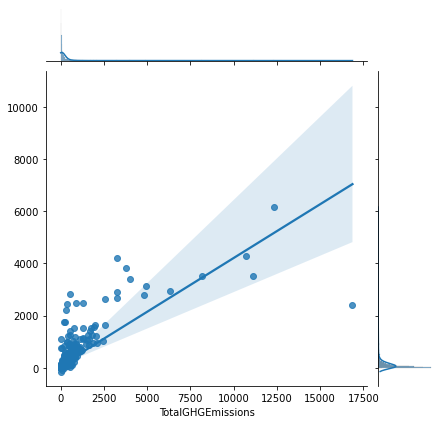

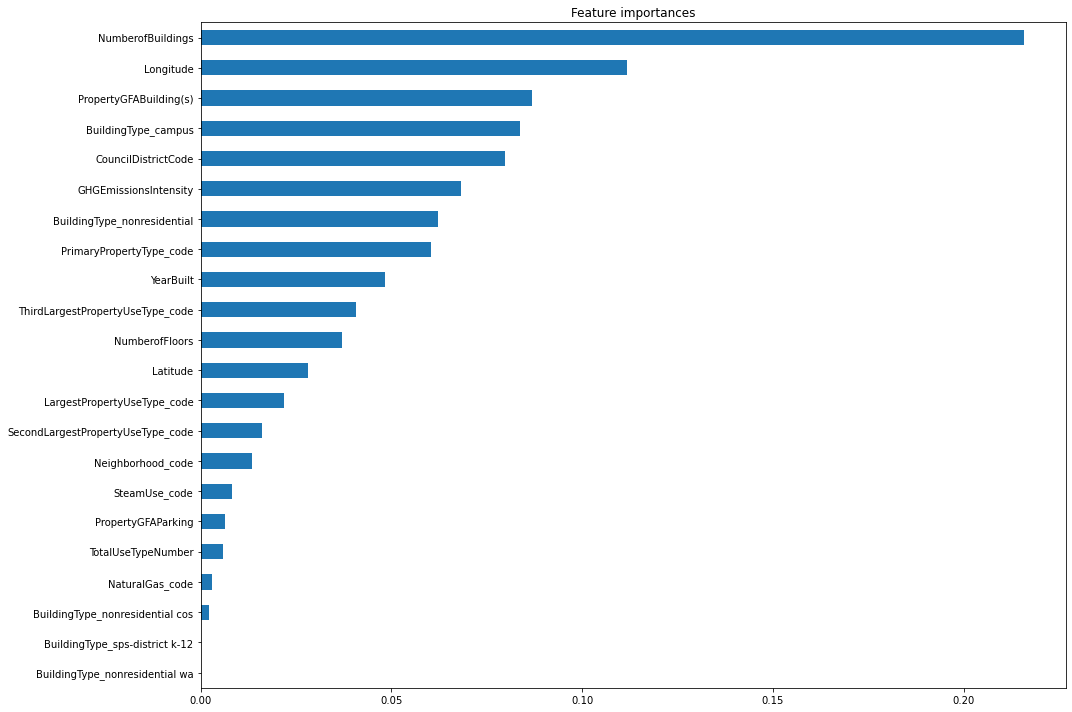

In [65]:
# recherche du meilleur paramètre avec GridSearchCV (score r2)
parameters = {
    'nthread':[4],
    'objective':['reg:squarederror'],
    'learning_rate': [0.03, 0.05, 0.07],
    'max_depth': [5, 6, 7],
    'min_child_weight': [4],
    'subsample': [0.3, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.5, 0.7],
    'n_estimators': [100, 400, 700],
}

model = GridSearchCV(XGBRegressor(), parameters, scoring=score_list, cv=5, refit='r2', error_score='raise', n_jobs=4)
model.fit(df_X, df_y['TotalGHGEmissions'])

print(model.best_estimator_)
print(model.best_params_)
scores = {k: model.cv_results_[k][model.best_index_] for k, v in model.cv_results_.items() if k.startswith('mean_test_')}
for k, v in scores.items():
    print(f"{k.upper()} -> {abs(v)}")
emission_results_r2['XGBRegressor'] = scores['mean_test_r2']
emission_results_rmse['XGBRegressor'] = abs(scores['mean_test_neg_root_mean_squared_error'])

y_pred = model_selection.cross_val_predict(model.best_estimator_, df_X, df_y['TotalGHGEmissions'], cv=5)
_ = sns.jointplot(x = df_y['TotalGHGEmissions'], y = y_pred, kind="reg")

emission_xgboost_feature_importance = pd.Series(model.best_estimator_.feature_importances_, index=df_X.columns).sort_values()
fig, ax = plt.subplots()
emission_xgboost_feature_importance.plot.barh(ax=ax)
ax.set_title("Feature importances")
fig.set_size_inches(15,10)
fig.tight_layout()

### Résultat des différents modèles

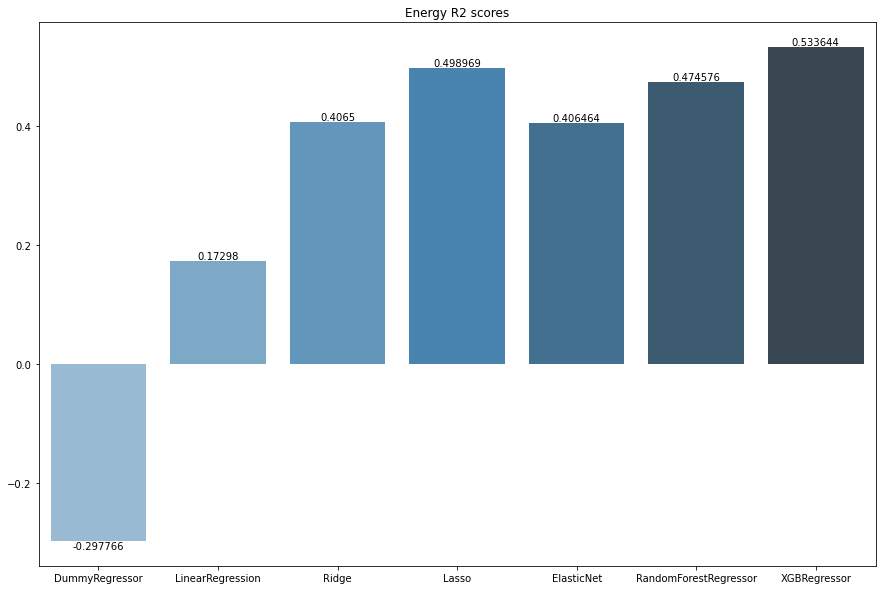

In [66]:
keys = list(energy_results_r2.keys())
values = [energy_results_r2[k] for k in keys]
plt.figure(figsize=(15,10))
plt.title("Energy R2 scores")
ax = sns.barplot(x=keys, y=values, palette='Blues_d')
_ = ax.bar_label(ax.containers[0])

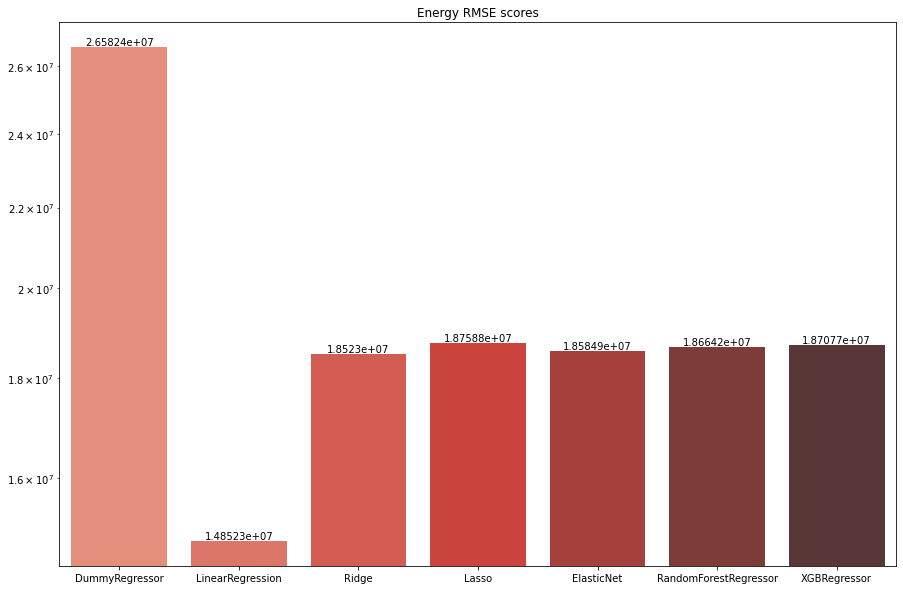

In [67]:
keys = list(energy_results_rmse.keys())
values = [energy_results_rmse[k] for k in keys]
plt.figure(figsize=(15,10))
plt.title("Energy RMSE scores")
plt.yscale('log')
ax = sns.barplot(x=keys, y=values, palette='Reds_d')
_ = ax.bar_label(ax.containers[0])

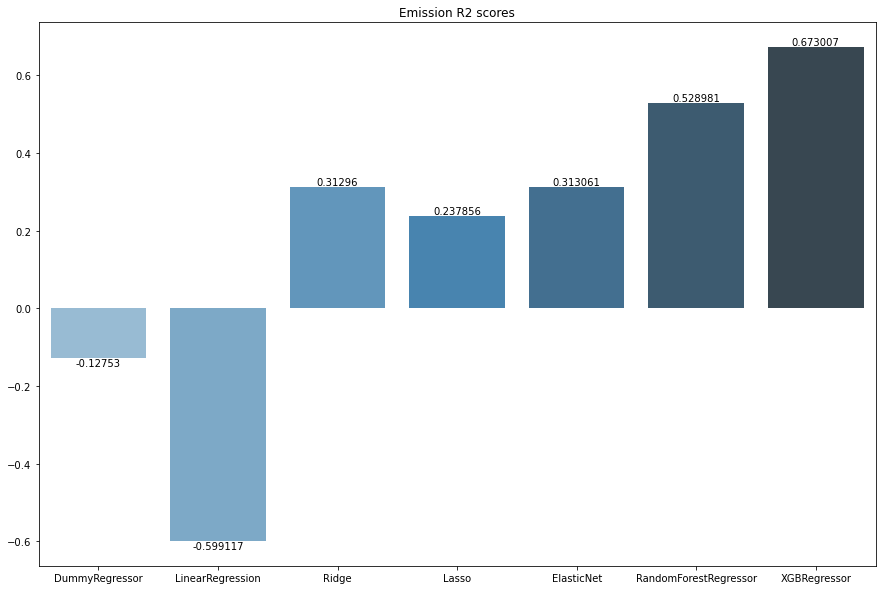

In [68]:
keys = list(emission_results_r2.keys())
values = [emission_results_r2[k] for k in keys]
plt.figure(figsize=(15,10))
plt.title("Emission R2 scores")
ax = sns.barplot(x=keys, y=values, palette='Blues_d')
_ = ax.bar_label(ax.containers[0])

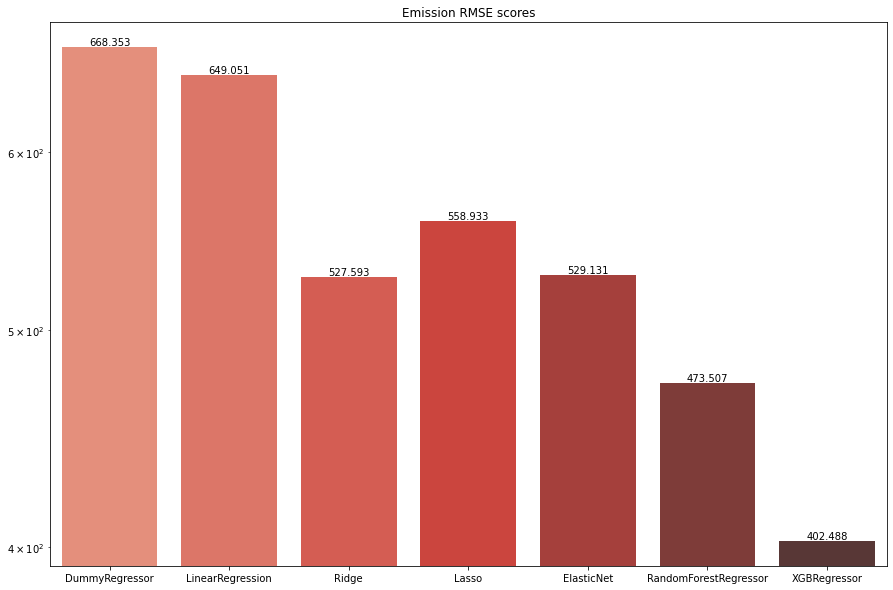

In [69]:
keys = list(emission_results_rmse.keys())
values = [emission_results_rmse[k] for k in keys]
plt.figure(figsize=(15,10))
plt.title("Emission RMSE scores")
plt.yscale('log')
ax = sns.barplot(x=keys, y=values, palette='Reds_d')
_ = ax.bar_label(ax.containers[0])

### Analyse avancée

In [70]:
model_list = {
    'DummyRegressor': {
        'model': DummyRegressor(),
        'params': {}
    },
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge': {
        'model': Ridge(),
        'params': {'alpha': np.logspace(-5, 10, 300)}
    },
    'Lasso': {
        'model': Lasso(),
        'params': {'alpha': np.logspace(-5, 10, 300)}
    },
    'ElasticNet': {
        'model': ElasticNet(),
        'params': {'alpha': np.logspace(-5, 10, 300)}
    },
    'RandomForestRegressor': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [100, 400, 700],
            'max_depth': [1, 2, 3, 4, 5, 6],
            'max_samples': [0.5, 1],
            'max_features': ['auto', 'sqrt'],
            'n_jobs': [4]
        }
    },
    'XGBRegressor': {
        'model': XGBRegressor(),
        'params': {
            'nthread':[4],
            'objective':['reg:squarederror'],
            'learning_rate': [0.03, 0.05, 0.07],
            'max_depth': [5, 6, 7],
            'min_child_weight': [4],
            'subsample': [0.3, 0.5, 0.7],
            'colsample_bytree': [0.3, 0.5, 0.7],
            'n_estimators': [100, 400, 700]
        }
    }
}

score_list = [
    'neg_mean_absolute_error',
    'neg_median_absolute_error',
    'neg_mean_squared_error',
    'neg_root_mean_squared_error',
    'r2'
]

column_list = {
    'params': 'params',
    'mean_fit_time': 'fit_time',
    'mean_score_time': 'score_time'
}

column_score_list = {
    'mean_test_neg_mean_absolute_error': 'mean_ae',
    'mean_test_neg_median_absolute_error': 'median_ae',
    'mean_test_neg_mean_squared_error': 'mean_se',
    'mean_test_neg_root_mean_squared_error': 'r_mean_se',
    'mean_test_r2': 'r2'
}

@ignore_warnings(category=ConvergenceWarning)
def run_grid_model(X, y, model, params={}):
    print('#', model.__class__.__name__)
    model = GridSearchCV(model, params, scoring=score_list, cv=5, refit='r2', n_jobs=4)
    model.fit(X, y)
    best_estimator = model.best_estimator_

    _df = pd.DataFrame(model.cv_results_)
    _df = _df[[*column_list, *column_score_list]]
    _df[list(column_score_list.keys())] = _df[list(column_score_list.keys())].abs()
    _df = _df.rename(columns={**column_list, **column_score_list})
    _df.loc[model.best_index_]

    _df['model'] = best_estimator.__class__.__name__
    _df['data'] = y.name

    return best_estimator, _df.iloc[[model.best_index_]]

def plot_estimator(X, y, estimator):
    y_pred = model_selection.cross_val_predict(estimator, X, y, cv=5)
    sns.jointplot(x = y, y = y_pred, kind="reg")
    plt.show()

def plot_scores(data, title=''):
    fig, ax = plt.subplots(1, 3, figsize=(25,7))
    fig.suptitle(title)

    sns.barplot(ax=ax[0], x='model', y='r2', data=data, palette='Blues_d')
    ax[0].set_title('R2 scores')
    ax[0].set_xticklabels(labels=ax[0].get_xticklabels(), rotation=90)
    ax[0].bar_label(ax[0].containers[0])

    sns.barplot(ax=ax[1], x='model', y='r_mean_se', data=data, palette='Reds_d')
    ax[1].set_title('RMSE scores')
    ax[1].set_xticklabels(labels=ax[1].get_xticklabels(), rotation=90)
    ax[1].bar_label(ax[1].containers[0])

    sns.barplot(ax=ax[2], x='model', y='fit_time', data=data, palette='Greys_d')
    ax[2].set_title('Fit time')
    ax[2].set_xticklabels(labels=ax[2].get_xticklabels(), rotation=90)
    ax[2].bar_label(ax[2].containers[0])

    plt.show()

@ignore_warnings(category=ConvergenceWarning)
def run_models(X, y, models, title=''):
    print('#'*20, title, '#'*20, '\n')
    print('shape:', X.shape, '\n')
    
    res = pd.DataFrame()
    y_pred_df = pd.DataFrame()

    for k, v in models.items():
        _best_estimator, _best_score = run_grid_model(X, y, model=v['model'], params=v['params'])
        res = pd.concat([res, _best_score], axis=0, verify_integrity=True, ignore_index=True)
        # plot_estimator(X, y, _best_estimator)
        y_pred = model_selection.cross_val_predict(_best_estimator, X, y, cv=5, n_jobs=4)
        y_pred_df = pd.concat(
            [y_pred_df, pd.DataFrame({'y': y, 'y_pred': y_pred, 'model': k})],
            axis=0,
            verify_integrity=True,
            ignore_index=True
        )
    
    sns.lmplot(x="y", y="y_pred", col="model", col_wrap=4, data=y_pred_df)
    plt.show()

    print('# Result')
    plot_scores(res, title=title)
    print('Best:', res.sort_values('r2', ascending=False, ignore_index=True).loc[0, ['data', 'model', 'r2']].to_dict(), '\n')

    return res

#################### Standardized data ('SiteEnergyUse(kBtu)') #################### 

shape: (1695, 22) 

# DummyRegressor
# LinearRegression
# Ridge
# Lasso
# ElasticNet
# RandomForestRegressor
# XGBRegressor


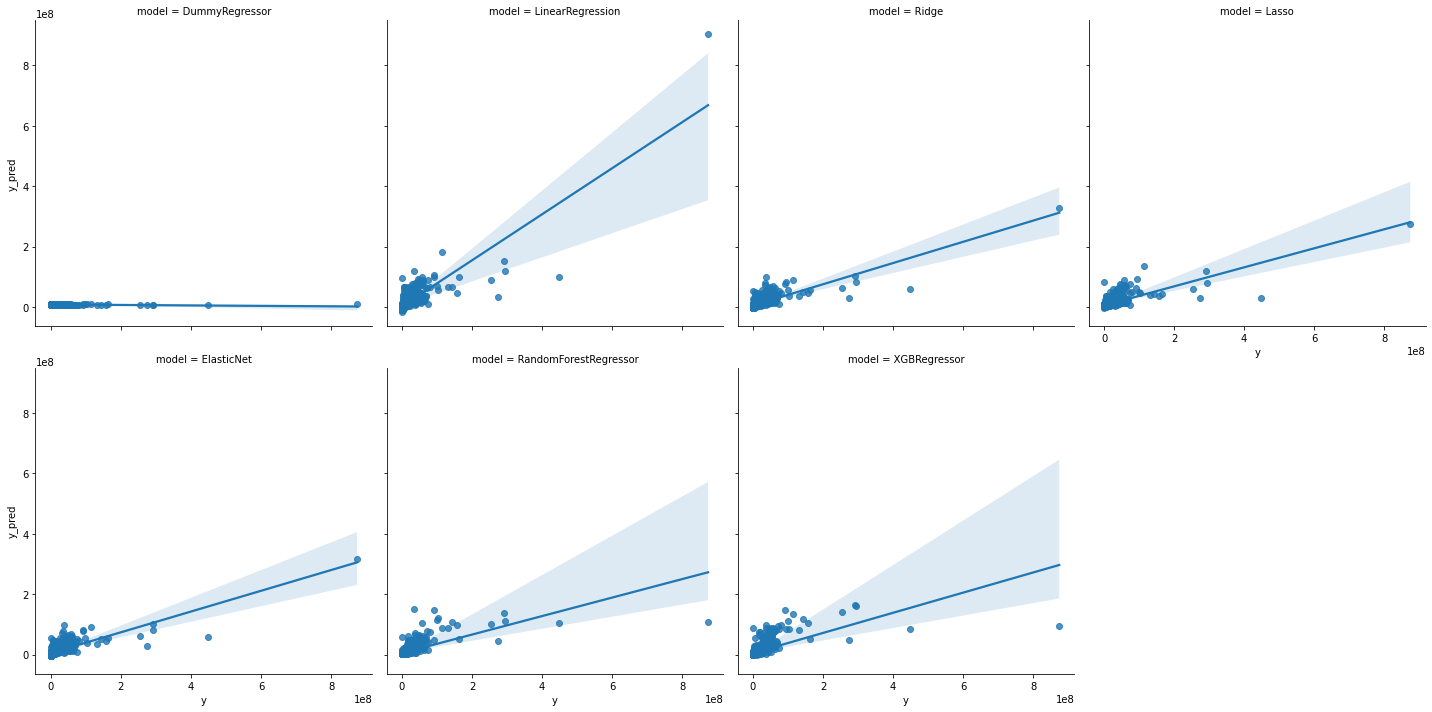

# Result


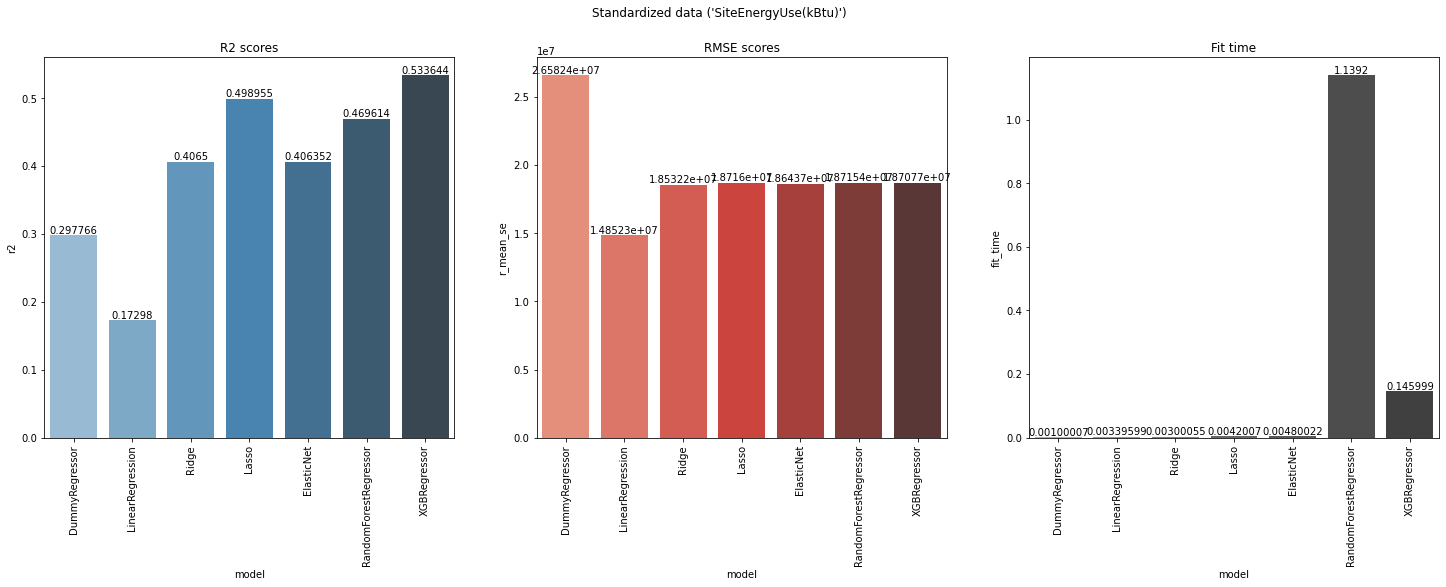

Best: {'data': 'SiteEnergyUse(kBtu)', 'model': 'XGBRegressor', 'r2': 0.5336441389123844} 

#################### Standardized data ('TotalGHGEmissions') #################### 

shape: (1695, 22) 

# DummyRegressor
# LinearRegression
# Ridge
# Lasso
# ElasticNet
# RandomForestRegressor
# XGBRegressor


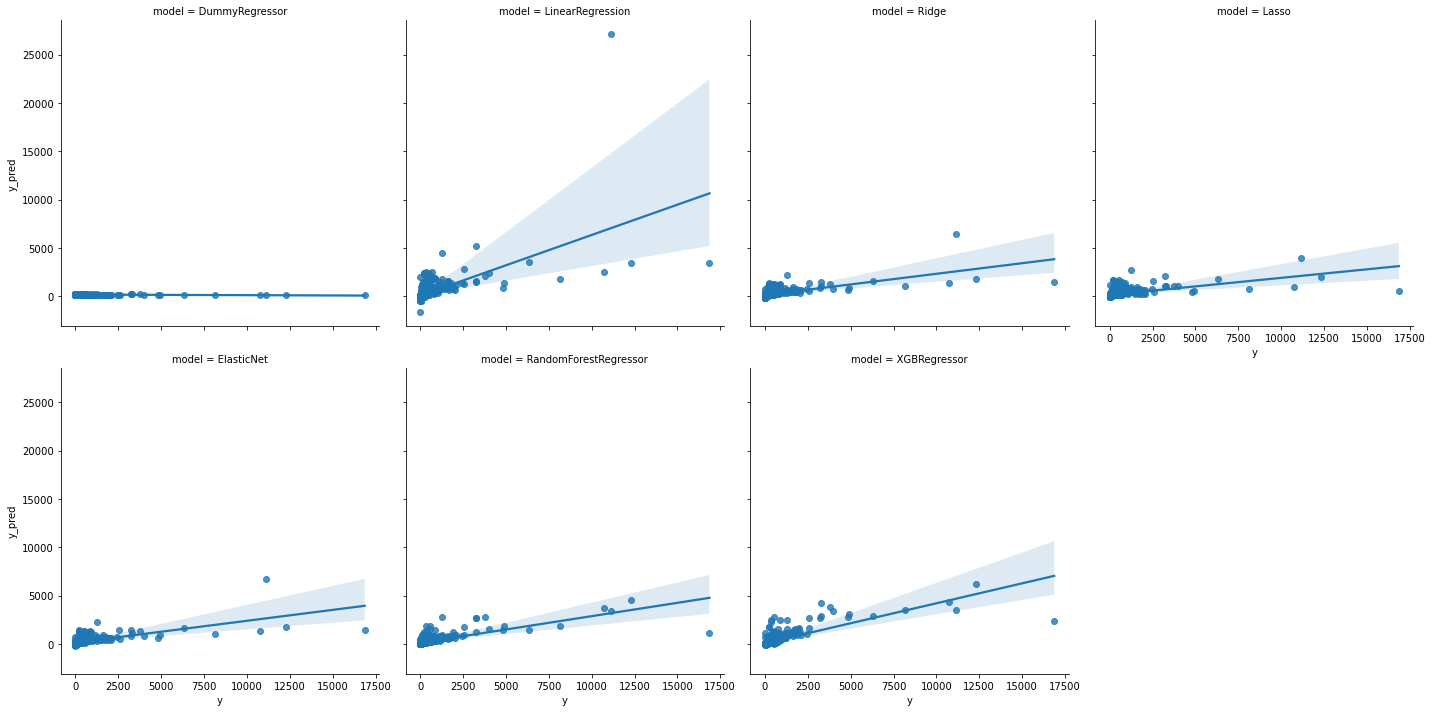

# Result


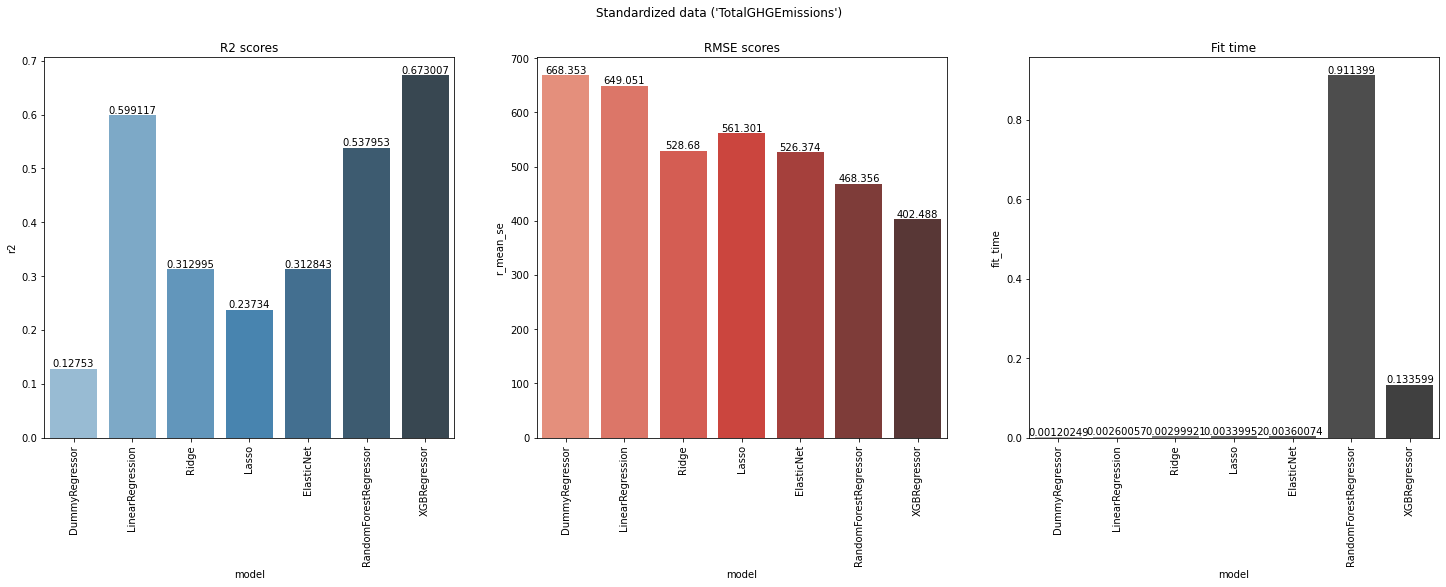

Best: {'data': 'TotalGHGEmissions', 'model': 'XGBRegressor', 'r2': 0.6730070928783487} 



In [71]:
# On prend toutes les features standardisées
_ = run_models(df_X, df_y['SiteEnergyUse(kBtu)'], model_list, title="Standardized data ('SiteEnergyUse(kBtu)')")
_ = run_models(df_X, df_y['TotalGHGEmissions'], model_list, title="Standardized data ('TotalGHGEmissions')")

#################### The 4 most important features standardized ('SiteEnergyUse(kBtu)') #################### 

shape: (1695, 4) 

# DummyRegressor
# LinearRegression
# Ridge
# Lasso
# ElasticNet
# RandomForestRegressor
# XGBRegressor


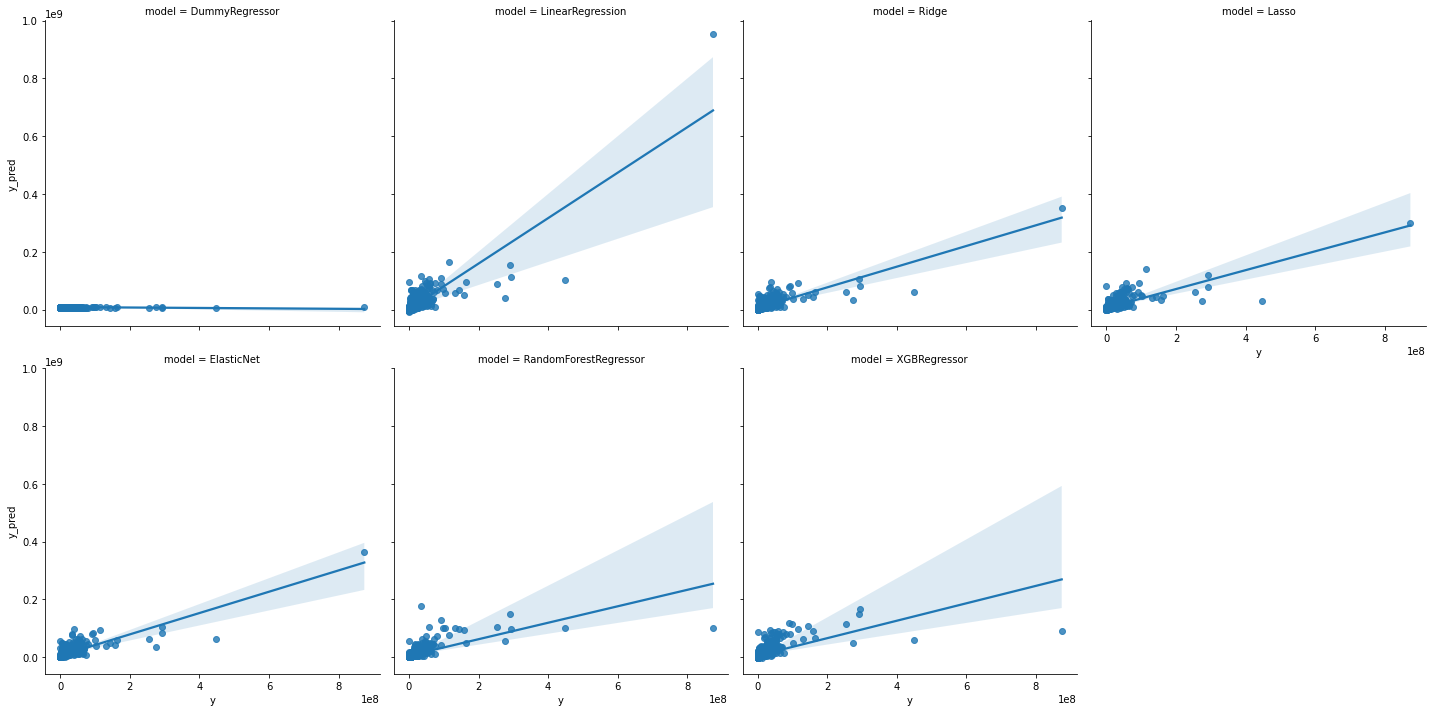

# Result


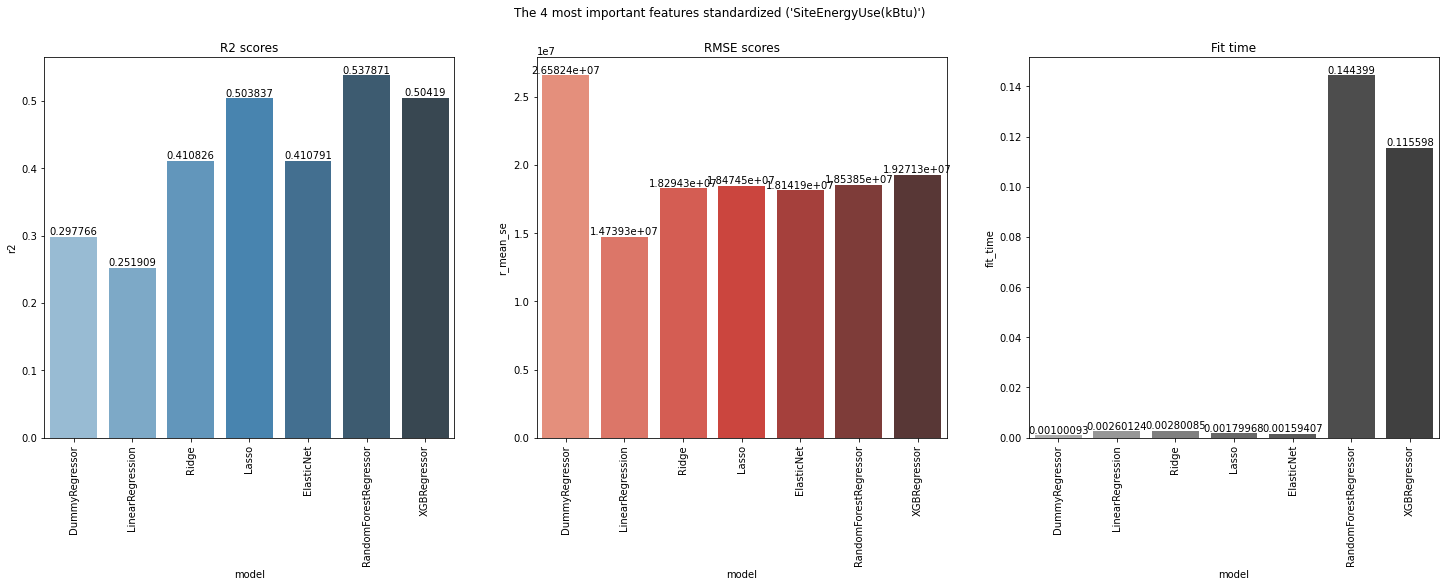

Best: {'data': 'SiteEnergyUse(kBtu)', 'model': 'RandomForestRegressor', 'r2': 0.537871001287102} 

#################### The 4 most important features standardized ('TotalGHGEmissions') #################### 

shape: (1695, 4) 

# DummyRegressor
# LinearRegression
# Ridge
# Lasso
# ElasticNet
# RandomForestRegressor
# XGBRegressor


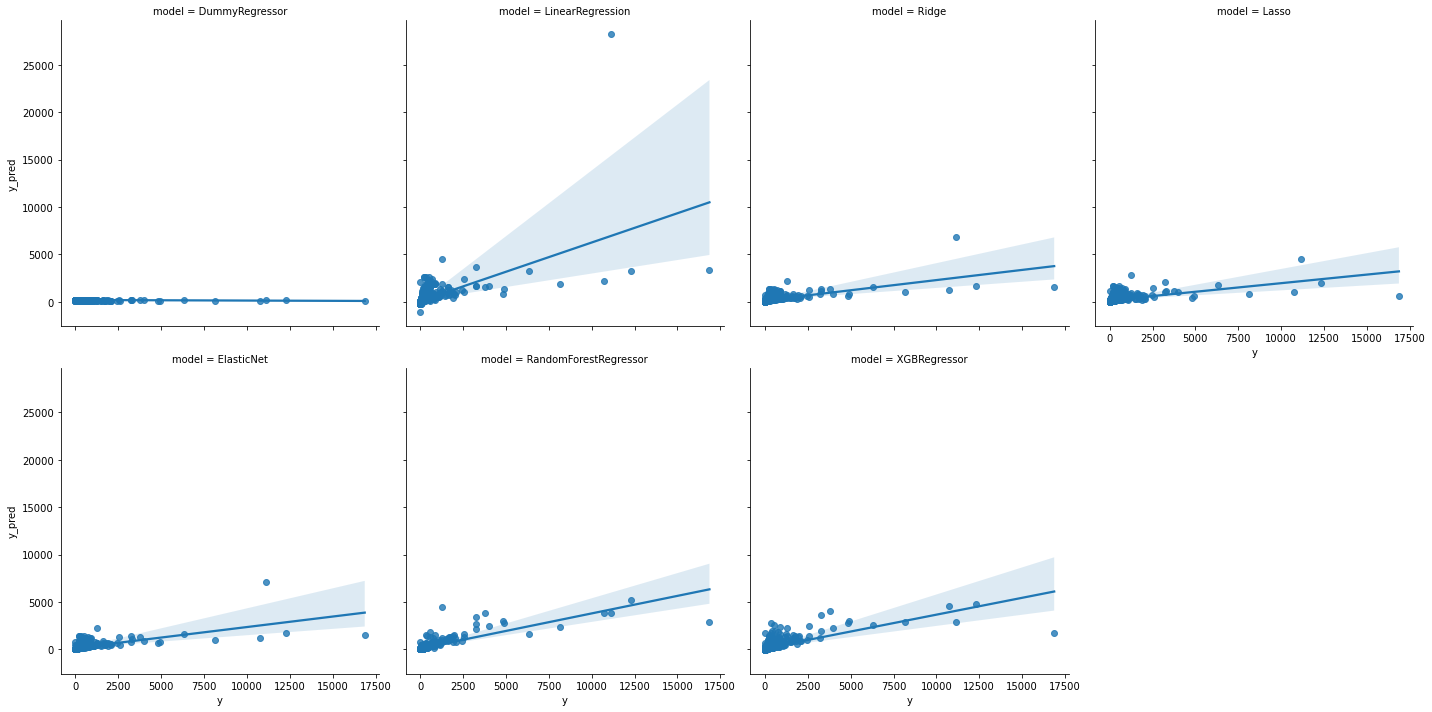

# Result


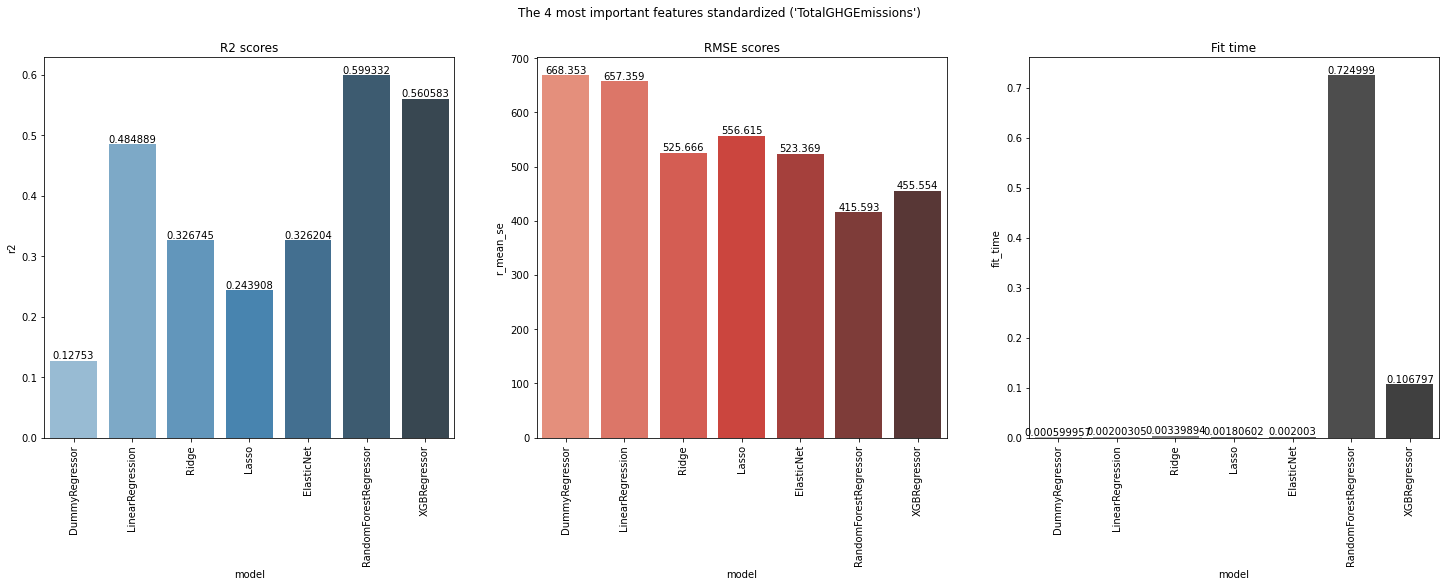

Best: {'data': 'TotalGHGEmissions', 'model': 'RandomForestRegressor', 'r2': 0.599332360805333} 



In [72]:
# On prend uniquement les 4 features les plus importantes
top_column = 4
_columns = list(energy_forest_feature_importance.sort_values(ascending=False)[0:top_column].index)
_ = run_models(df_X[_columns], df_y['SiteEnergyUse(kBtu)'], model_list, title="The 4 most important features standardized ('SiteEnergyUse(kBtu)')")
_columns = list(emission_forest_feature_importance.sort_values(ascending=False)[0:top_column].index)
_ = run_models(df_X[_columns], df_y['TotalGHGEmissions'], model_list, title="The 4 most important features standardized ('TotalGHGEmissions')")

#################### The 8 most important features standardized ('SiteEnergyUse(kBtu)') #################### 

shape: (1695, 8) 

# DummyRegressor
# LinearRegression
# Ridge
# Lasso
# ElasticNet
# RandomForestRegressor
# XGBRegressor


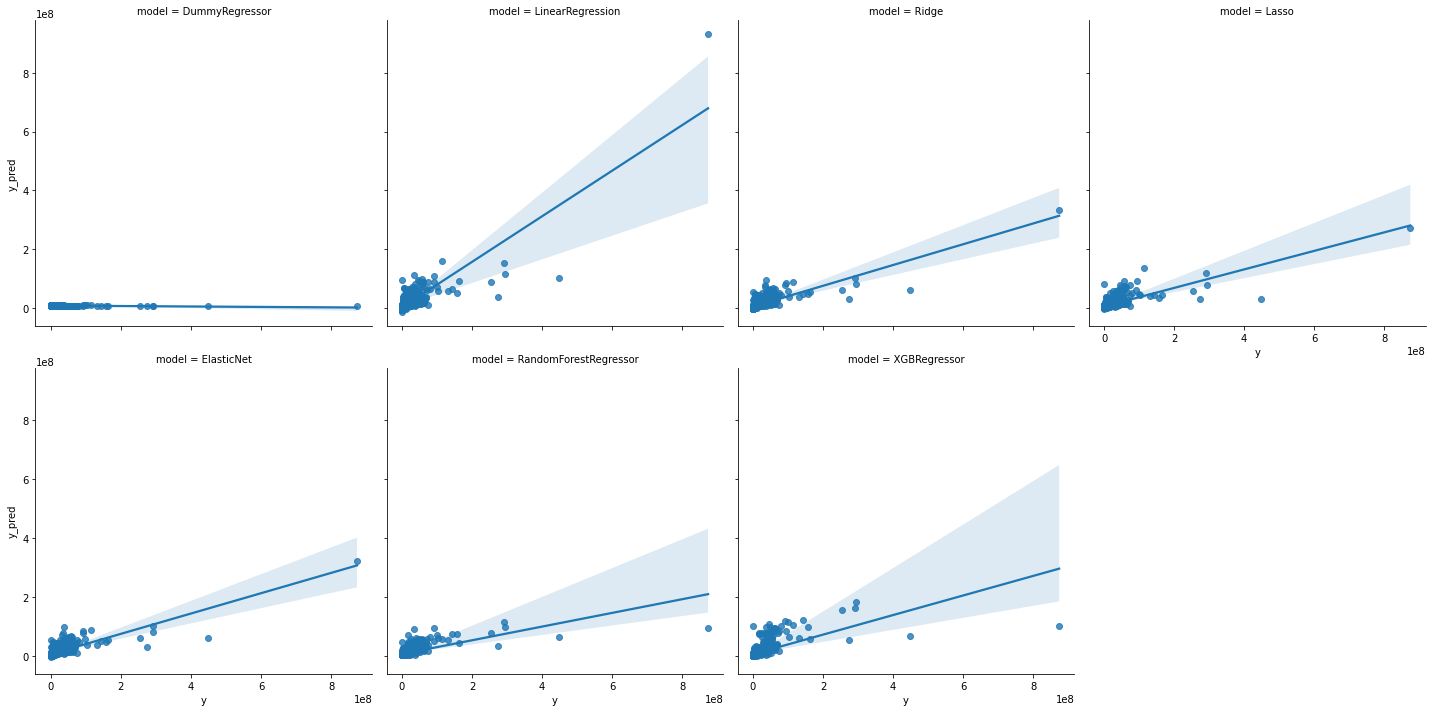

# Result


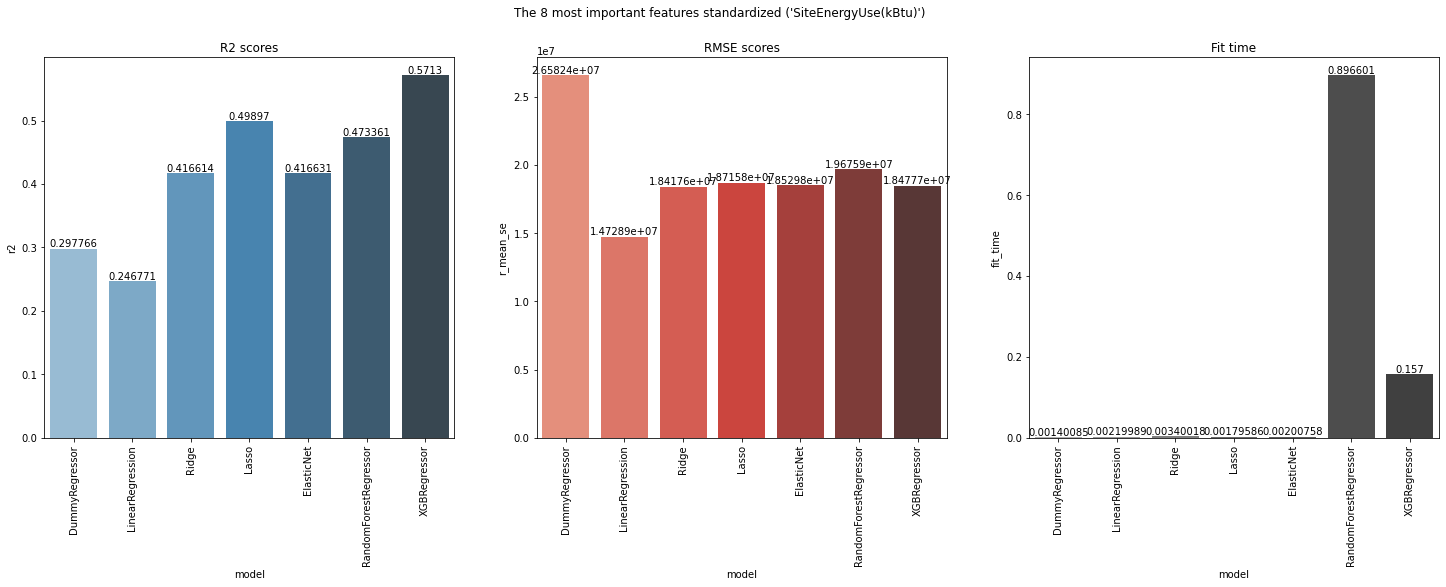

Best: {'data': 'SiteEnergyUse(kBtu)', 'model': 'XGBRegressor', 'r2': 0.5713003071079734} 

#################### The 8 most important features standardized ('TotalGHGEmissions') #################### 

shape: (1695, 8) 

# DummyRegressor
# LinearRegression
# Ridge
# Lasso
# ElasticNet
# RandomForestRegressor
# XGBRegressor


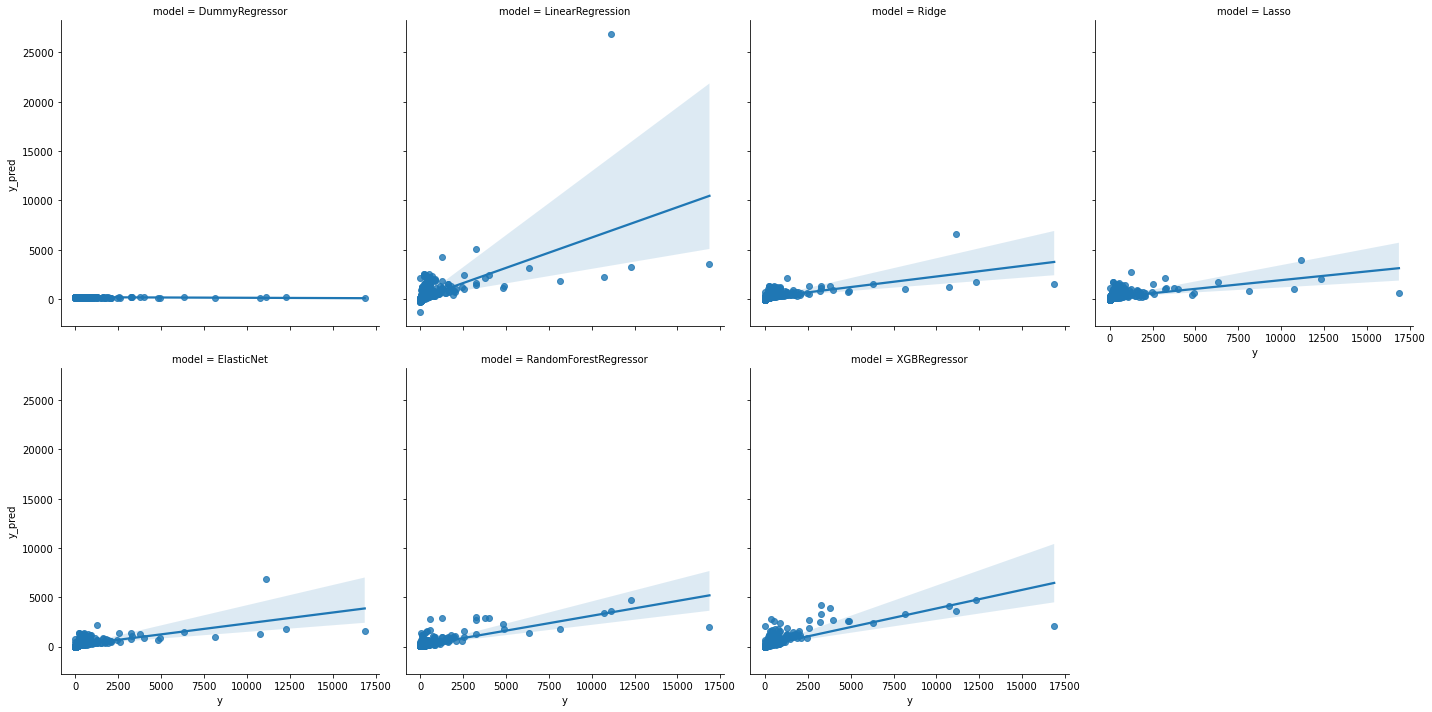

# Result


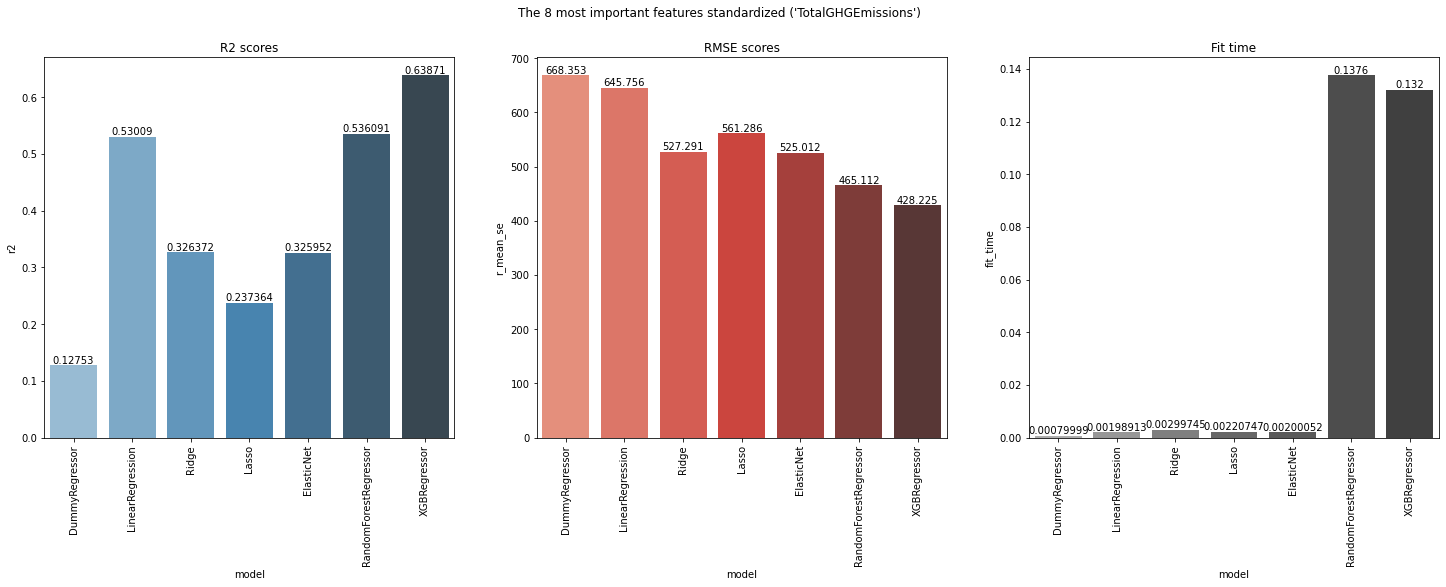

Best: {'data': 'TotalGHGEmissions', 'model': 'XGBRegressor', 'r2': 0.6387098601680773} 



In [73]:
# On prend uniquement les 8 features les plus importantes
top_column = 8
_columns = list(energy_forest_feature_importance.sort_values(ascending=False)[0:top_column].index)
_ = run_models(df_X[_columns], df_y['SiteEnergyUse(kBtu)'], model_list, title="The 8 most important features standardized ('SiteEnergyUse(kBtu)')")
_columns = list(emission_forest_feature_importance.sort_values(ascending=False)[0:top_column].index)
_ = run_models(df_X[_columns], df_y['TotalGHGEmissions'], model_list, title="The 8 most important features standardized ('TotalGHGEmissions')")

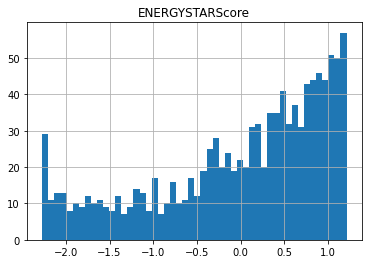

#################### Standardized data with ENERGYSTARScore ('SiteEnergyUse(kBtu)') #################### 

shape: (1112, 23) 

# DummyRegressor
# LinearRegression
# Ridge
# Lasso
# ElasticNet
# RandomForestRegressor
# XGBRegressor


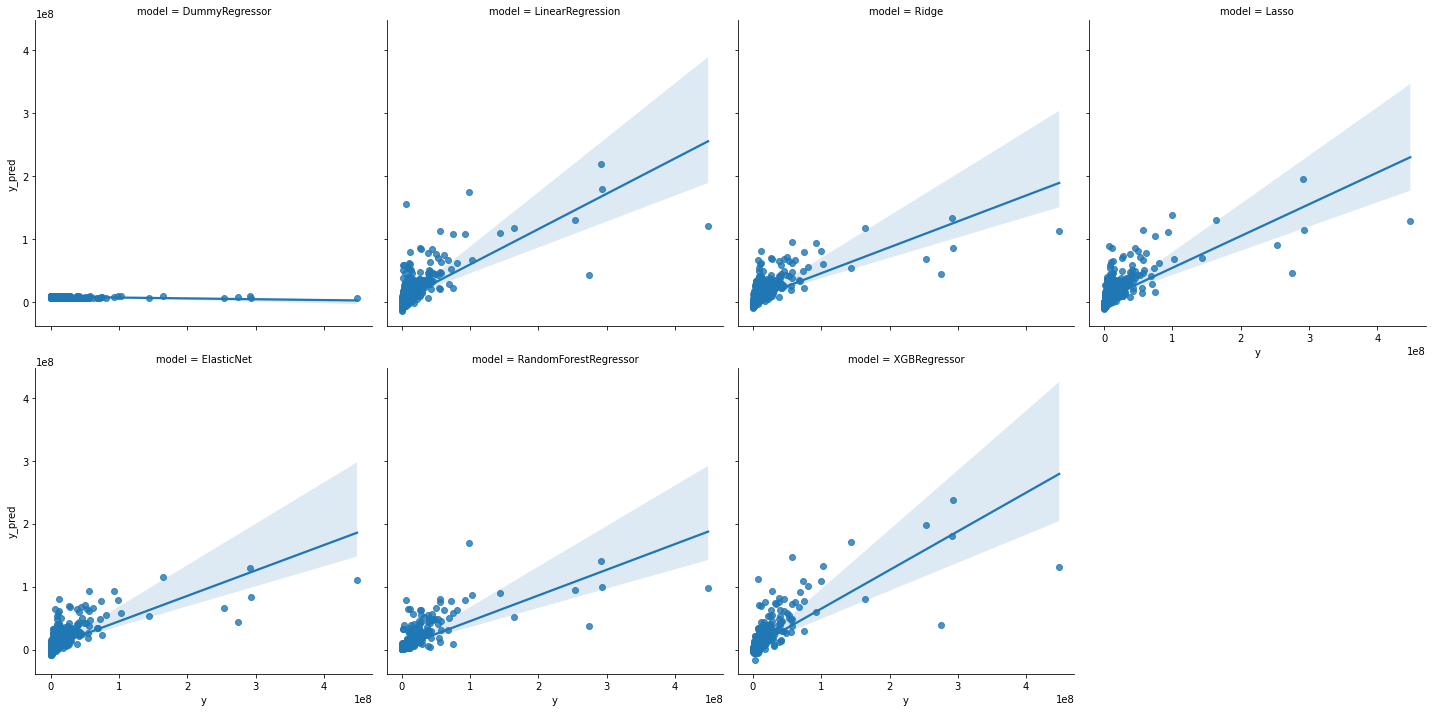

# Result


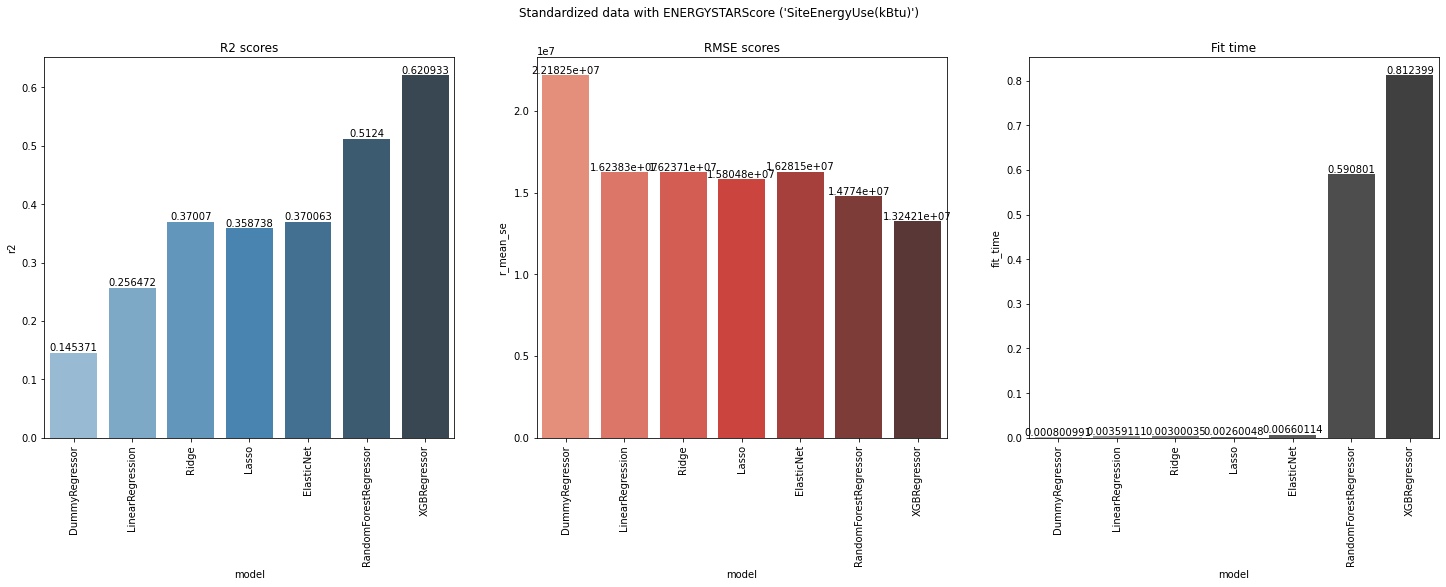

Best: {'data': 'SiteEnergyUse(kBtu)', 'model': 'XGBRegressor', 'r2': 0.6209327676187053} 

#################### Standardized data with ENERGYSTARScore ('TotalGHGEmissions') #################### 

shape: (1112, 23) 

# DummyRegressor
# LinearRegression
# Ridge
# Lasso
# ElasticNet
# RandomForestRegressor
# XGBRegressor


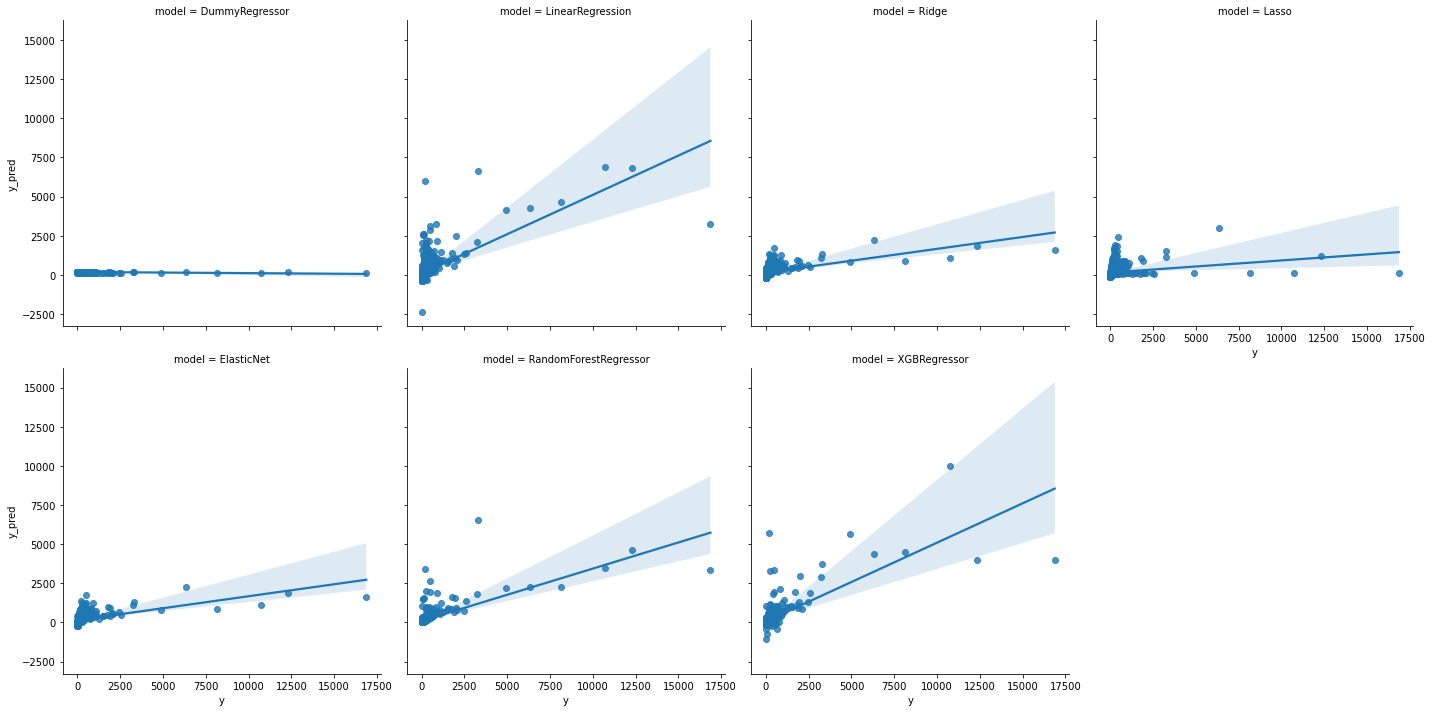

# Result


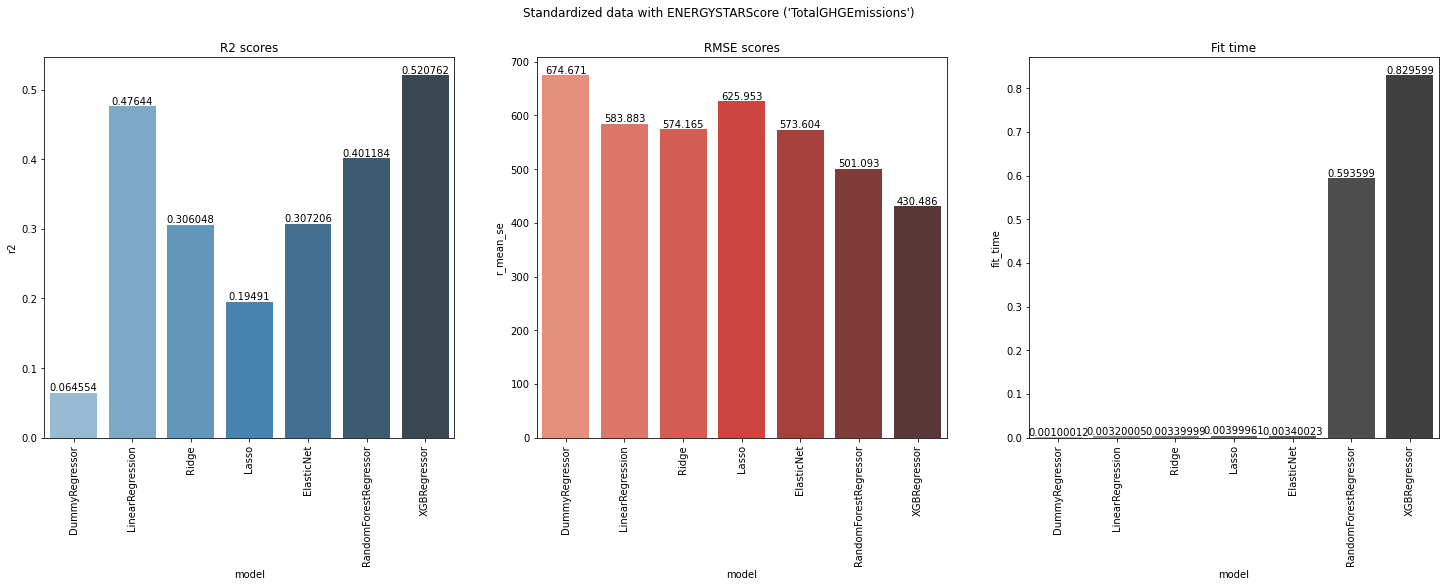

Best: {'data': 'TotalGHGEmissions', 'model': 'XGBRegressor', 'r2': 0.5207618115542381} 



In [74]:
# On ajoute l'energy star score standardisé
df_reg2 = df_reg.copy()
df_reg2['ENERGYSTARScore'] = df_final['ENERGYSTARScore']
df_reg2.dropna(subset=['ENERGYSTARScore'], inplace=True)

df_X2 = df_reg2.drop(['TotalGHGEmissions', 'SiteEnergyUse(kBtu)'], axis=1)
df_y2 = df_reg2[['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']]

df_X2['ENERGYSTARScore'] = StandardScaler().fit_transform(df_X2[['ENERGYSTARScore']])
pd.DataFrame(df_X2['ENERGYSTARScore']).hist(bins=50)
plt.show()

_ = run_models(df_X2, df_y2['SiteEnergyUse(kBtu)'], model_list, title="Standardized data with ENERGYSTARScore ('SiteEnergyUse(kBtu)')")
_ = run_models(df_X2, df_y2['TotalGHGEmissions'], model_list, title="Standardized data with ENERGYSTARScore ('TotalGHGEmissions')")


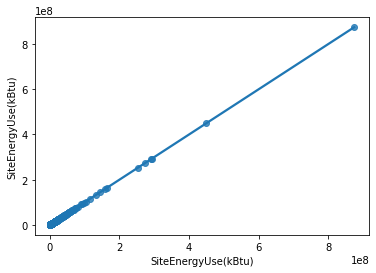

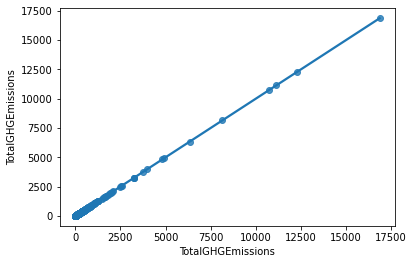

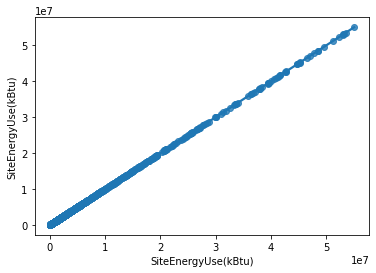

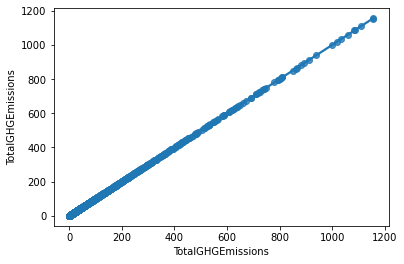

In [75]:
sns.regplot(x='SiteEnergyUse(kBtu)', y='SiteEnergyUse(kBtu)', data=df_reg)
plt.show()
sns.regplot(x='TotalGHGEmissions', y='TotalGHGEmissions', data=df_reg)
plt.show()
sns.regplot(x='SiteEnergyUse(kBtu)', y='SiteEnergyUse(kBtu)', data=df_reg.loc[df_reg['SiteEnergyUse(kBtu)'] < df_reg['SiteEnergyUse(kBtu)'].quantile(0.98), ['SiteEnergyUse(kBtu)']])
plt.show()
sns.regplot(x='TotalGHGEmissions', y='TotalGHGEmissions', data=df_reg.loc[df_reg['TotalGHGEmissions'] < df_reg['TotalGHGEmissions'].quantile(0.98), ['TotalGHGEmissions']])
plt.show()



#################### Standardized data 0.98 quantile ('SiteEnergyUse(kBtu)') #################### 

shape: (1661, 22) 

# DummyRegressor
# LinearRegression
# Ridge
# Lasso
# ElasticNet
# RandomForestRegressor
# XGBRegressor


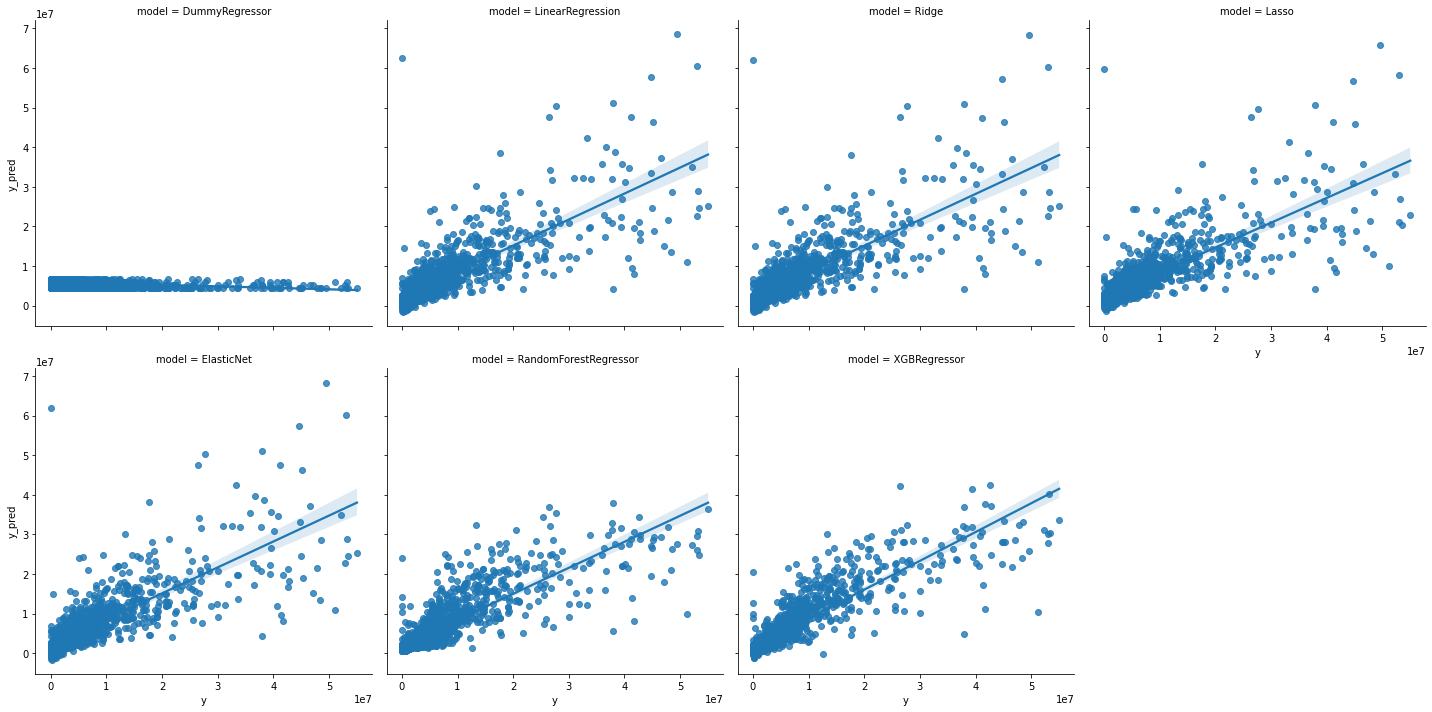

# Result


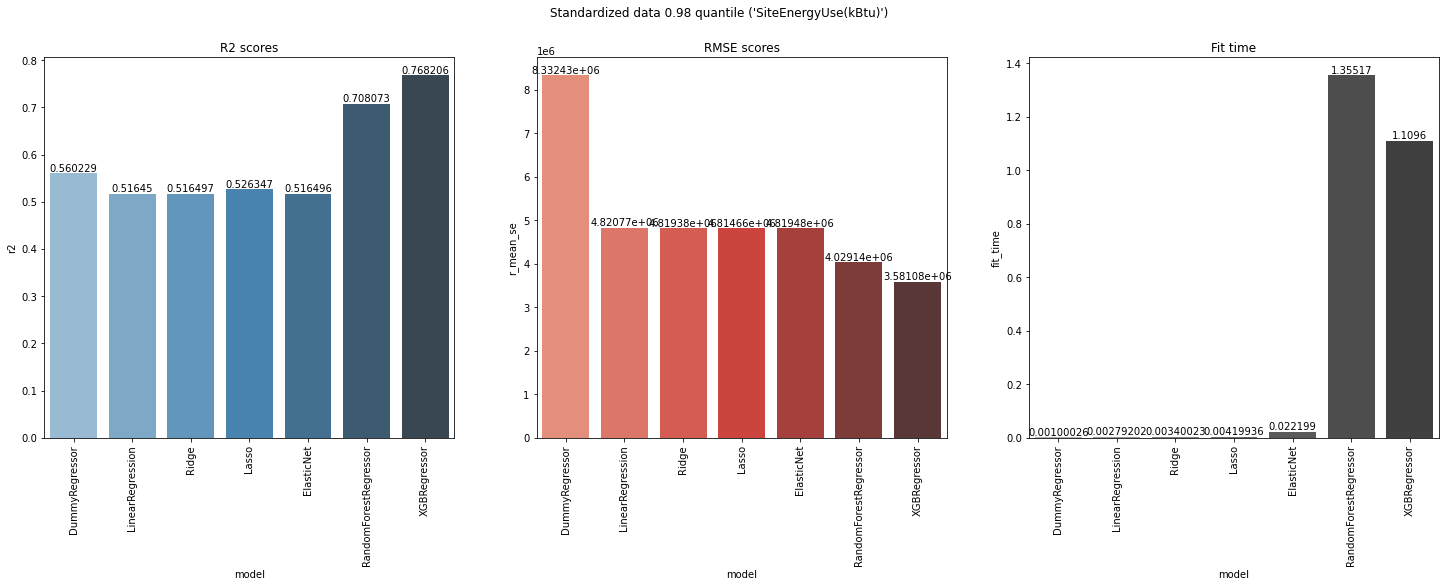

Best: {'data': 'SiteEnergyUse(kBtu)', 'model': 'XGBRegressor', 'r2': 0.7682062794072231} 

#################### Standardized data 0.98 quantile ('TotalGHGEmissions') #################### 

shape: (1661, 22) 

# DummyRegressor
# LinearRegression
# Ridge
# Lasso
# ElasticNet
# RandomForestRegressor
# XGBRegressor


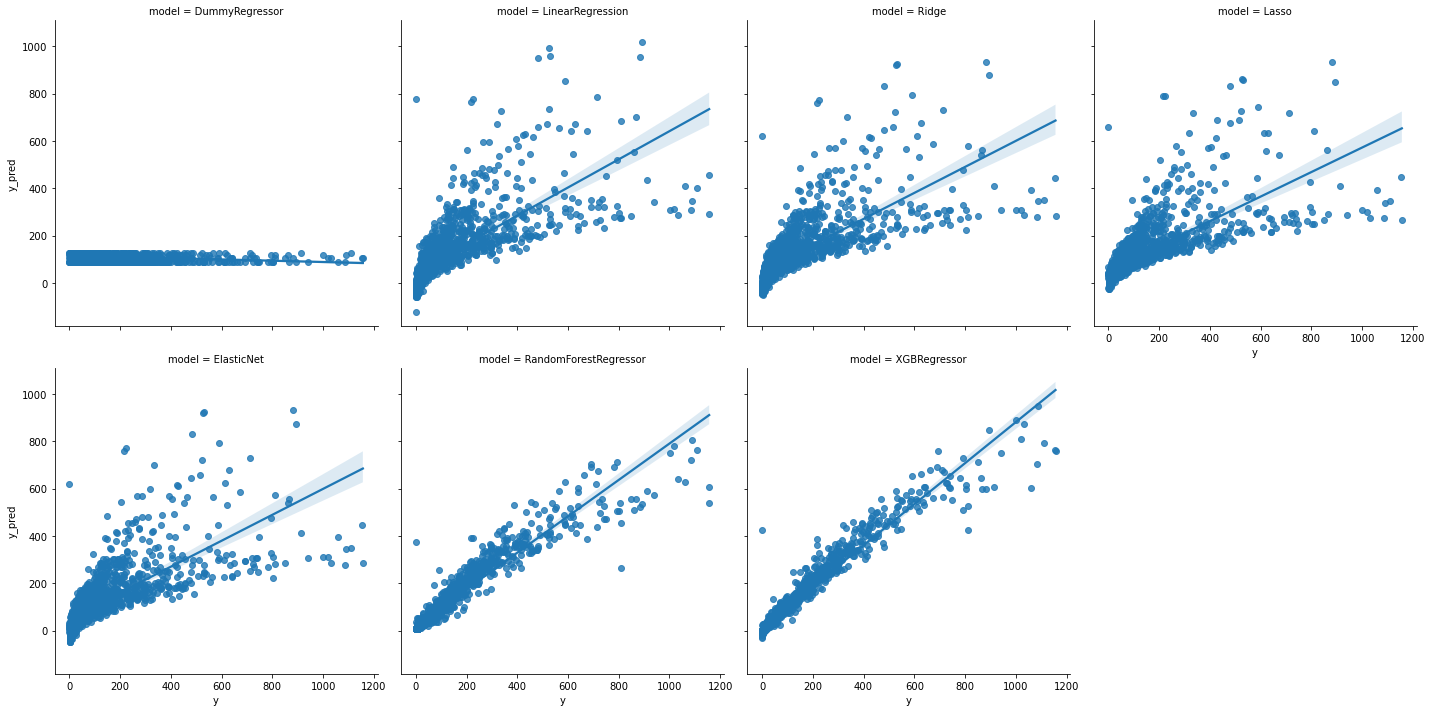

# Result


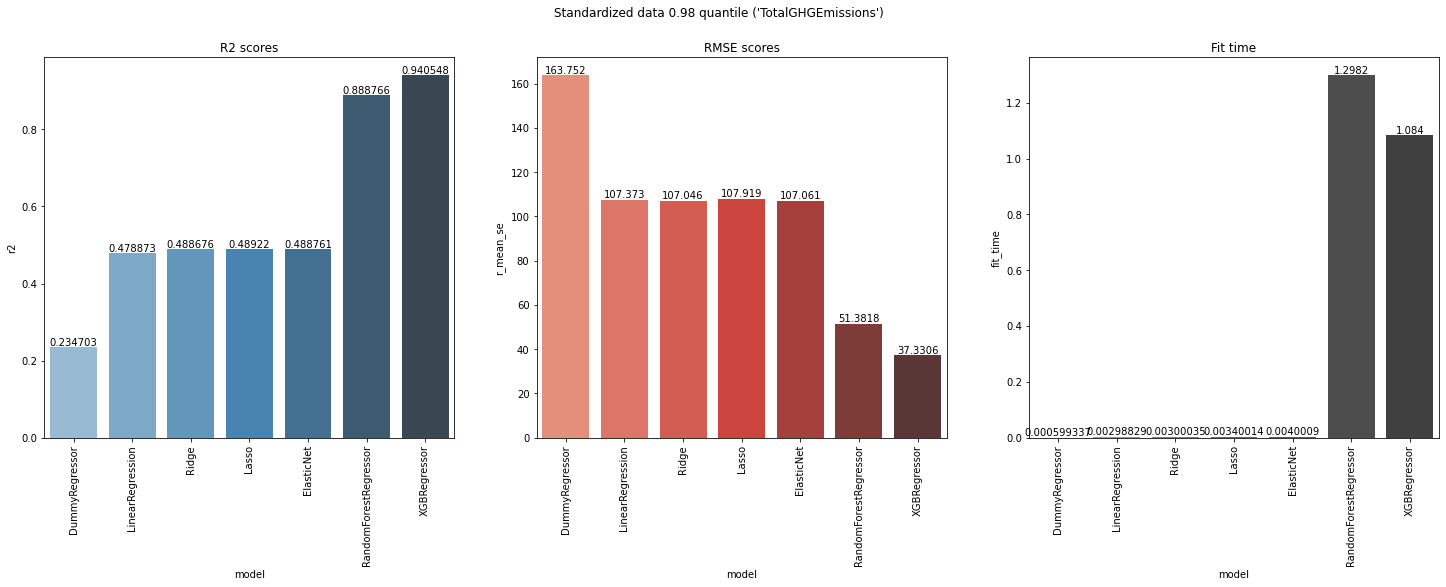

Best: {'data': 'TotalGHGEmissions', 'model': 'XGBRegressor', 'r2': 0.9405484133225954} 



In [76]:
df_reg30 = df_reg.loc[df_reg['SiteEnergyUse(kBtu)'] < df_reg['SiteEnergyUse(kBtu)'].quantile(0.98)]
_ = run_models(df_reg30.drop(['TotalGHGEmissions', 'SiteEnergyUse(kBtu)'], axis=1), df_reg30['SiteEnergyUse(kBtu)'], model_list, title="Standardized data 0.98 quantile ('SiteEnergyUse(kBtu)')")
df_reg31 = df_reg.loc[df_reg['TotalGHGEmissions'] < df_reg['TotalGHGEmissions'].quantile(0.98)]
_ = run_models(df_reg31.drop(['TotalGHGEmissions', 'SiteEnergyUse(kBtu)'], axis=1), df_reg31['TotalGHGEmissions'], model_list, title="Standardized data 0.98 quantile ('TotalGHGEmissions')")

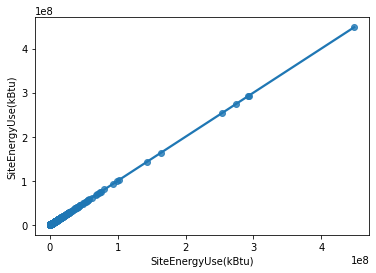

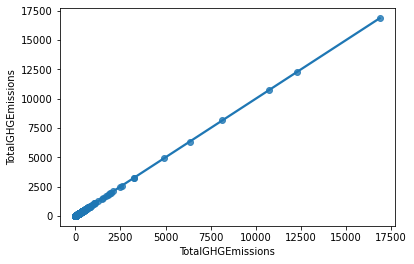

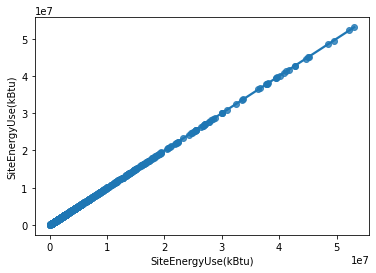

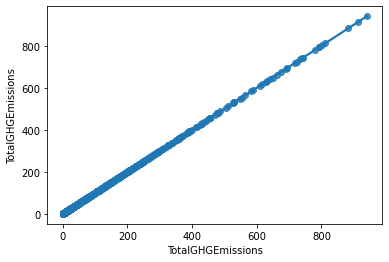

In [77]:
df_reg2 = df_reg.copy()
df_reg2['ENERGYSTARScore'] = df_final['ENERGYSTARScore']
df_reg2.dropna(subset=['ENERGYSTARScore'], inplace=True)

sns.regplot(x='SiteEnergyUse(kBtu)', y='SiteEnergyUse(kBtu)', data=df_reg2)
plt.show()
sns.regplot(x='TotalGHGEmissions', y='TotalGHGEmissions', data=df_reg2)
plt.show()
sns.regplot(x='SiteEnergyUse(kBtu)', y='SiteEnergyUse(kBtu)', data=df_reg2.loc[df_reg2['SiteEnergyUse(kBtu)'] < df_reg2['SiteEnergyUse(kBtu)'].quantile(0.98), ['SiteEnergyUse(kBtu)']])
plt.show()
sns.regplot(x='TotalGHGEmissions', y='TotalGHGEmissions', data=df_reg2.loc[df_reg2['TotalGHGEmissions'] < df_reg2['TotalGHGEmissions'].quantile(0.98), ['TotalGHGEmissions']])
plt.show()

#################### Standardized data 0.98 quantile with ENERGYSTARScore ('SiteEnergyUse(kBtu)') #################### 

shape: (1089, 23) 

# DummyRegressor
# LinearRegression
# Ridge
# Lasso
# ElasticNet
# RandomForestRegressor
# XGBRegressor


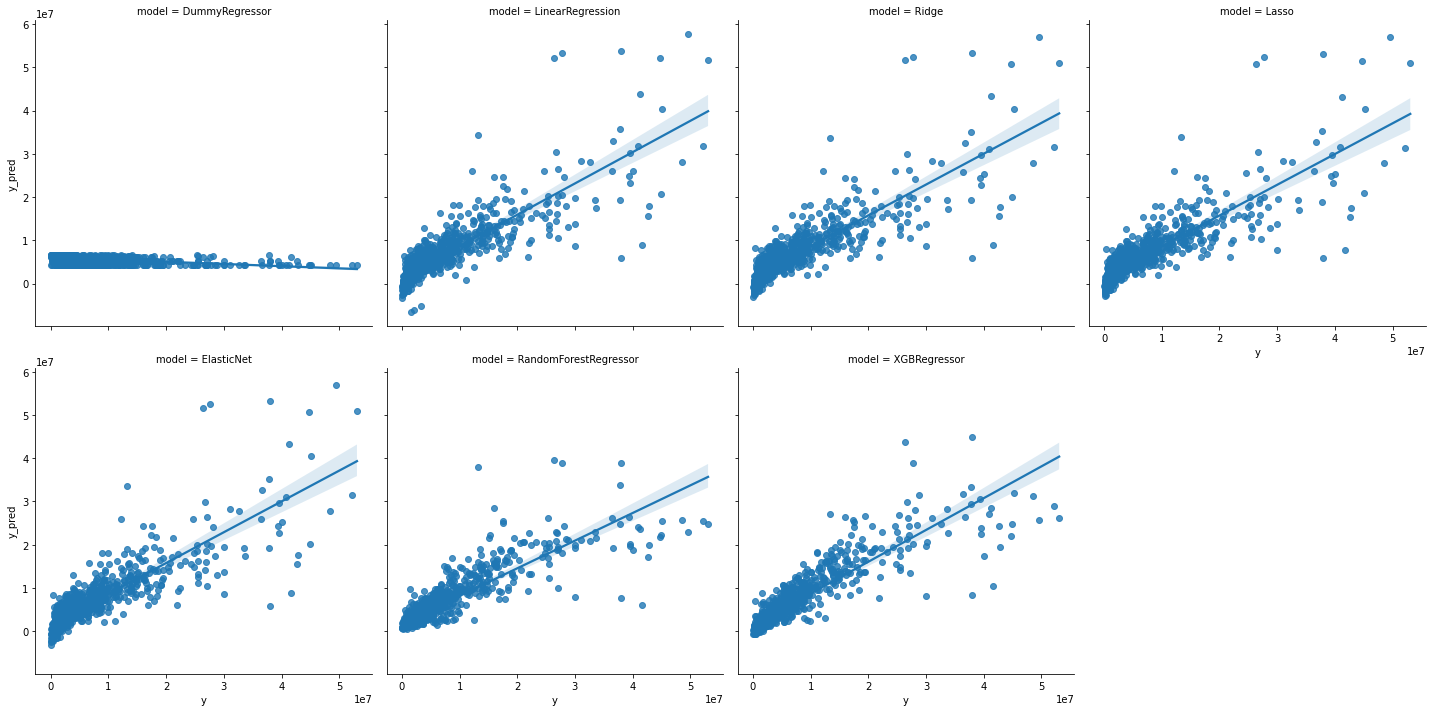

# Result


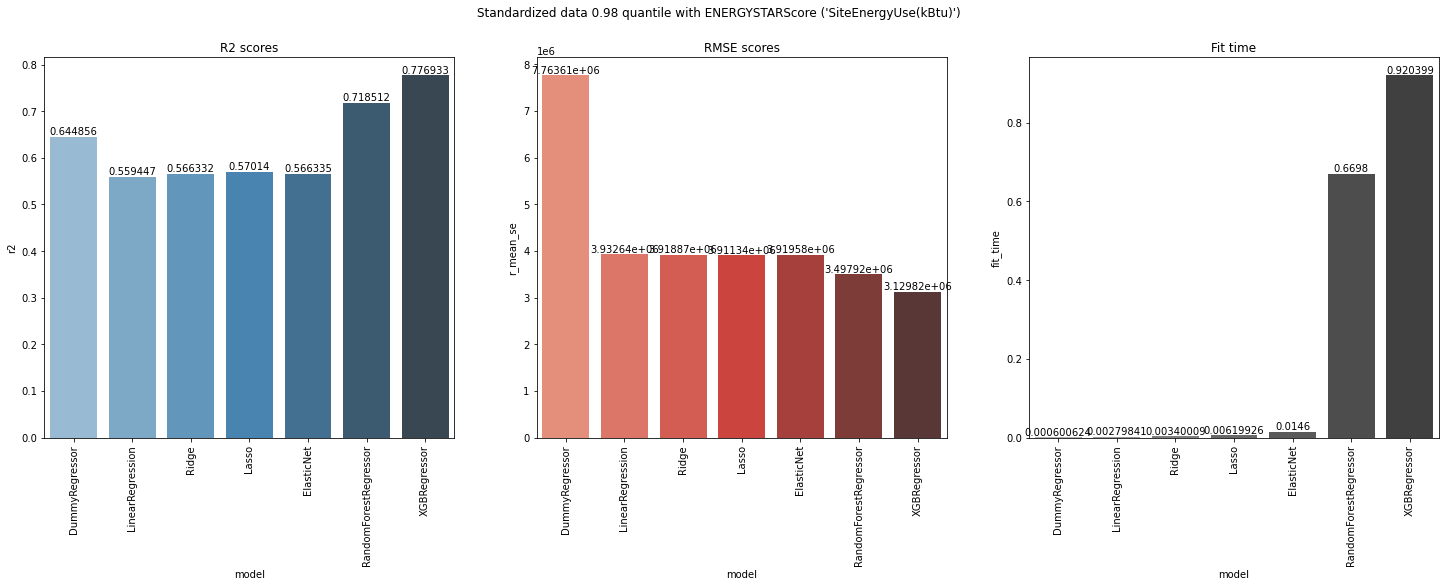

Best: {'data': 'SiteEnergyUse(kBtu)', 'model': 'XGBRegressor', 'r2': 0.7769325310174963} 

#################### Standardized data 0.98 quantile with ENERGYSTARScore ('TotalGHGEmissions') #################### 

shape: (1089, 23) 

# DummyRegressor
# LinearRegression
# Ridge
# Lasso
# ElasticNet
# RandomForestRegressor
# XGBRegressor


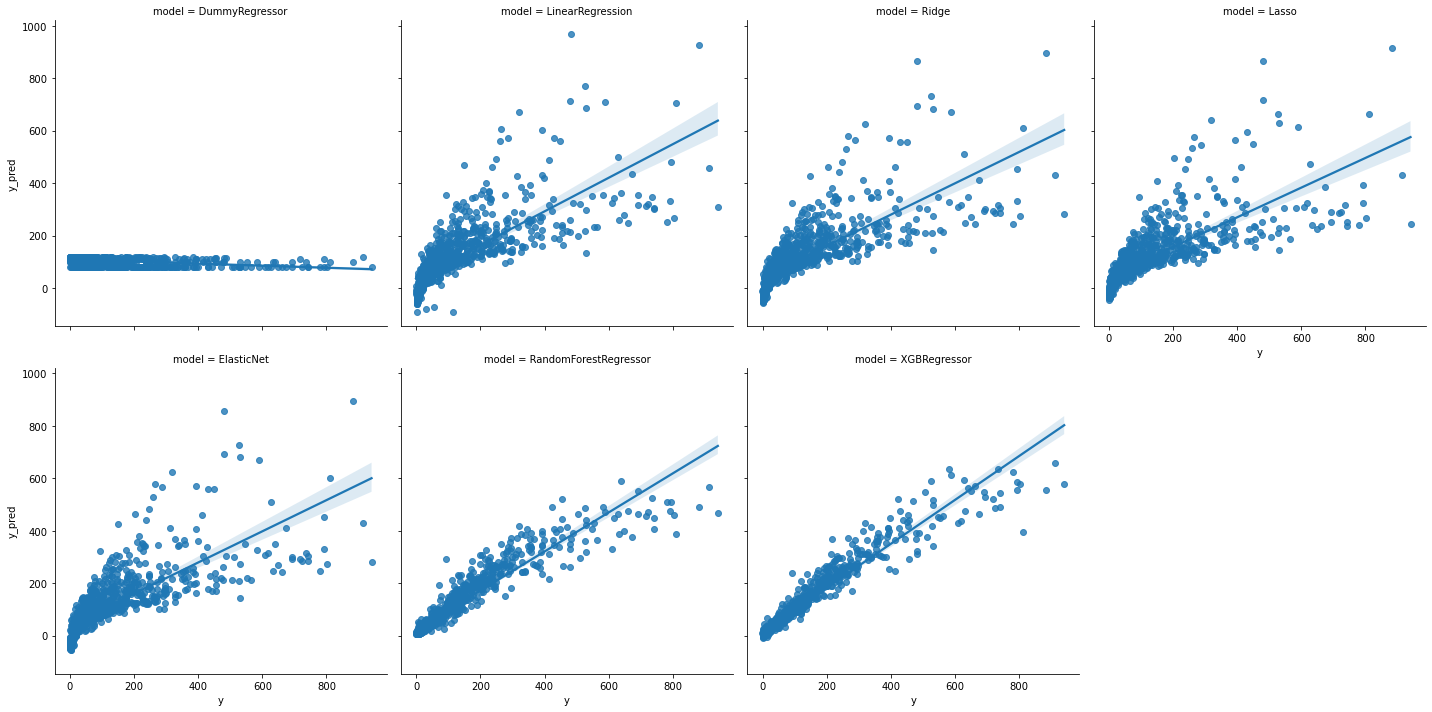

# Result


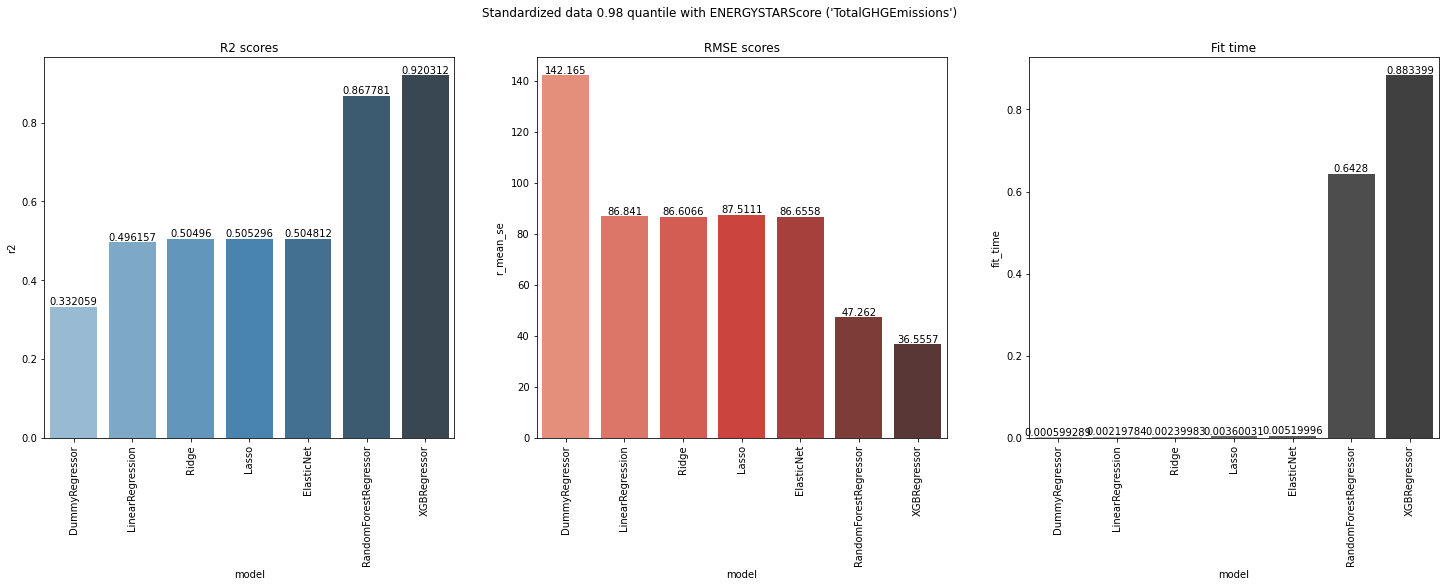

Best: {'data': 'TotalGHGEmissions', 'model': 'XGBRegressor', 'r2': 0.9203115669951334} 



In [78]:
df_reg4 = df_reg.copy()
df_reg4['ENERGYSTARScore'] = df_final['ENERGYSTARScore']
df_reg4.dropna(subset=['ENERGYSTARScore'], inplace=True)

df_reg40 = df_reg4.loc[df_reg4['SiteEnergyUse(kBtu)'] < df_reg4['SiteEnergyUse(kBtu)'].quantile(0.98)]
_ = run_models(df_reg40.drop(['TotalGHGEmissions', 'SiteEnergyUse(kBtu)'], axis=1), df_reg40['SiteEnergyUse(kBtu)'], model_list, title="Standardized data 0.98 quantile with ENERGYSTARScore ('SiteEnergyUse(kBtu)')")
df_reg41 = df_reg4.loc[df_reg['TotalGHGEmissions'] < df_reg4['TotalGHGEmissions'].quantile(0.98)]
_ = run_models(df_reg41.drop(['TotalGHGEmissions', 'SiteEnergyUse(kBtu)'], axis=1), df_reg41['TotalGHGEmissions'], model_list, title="Standardized data 0.98 quantile with ENERGYSTARScore ('TotalGHGEmissions')")

### Export du notebook en HTML

In [81]:
!jupyter nbconvert --config nbconvert/config_html

[NbConvertApp] Converting notebook Pélec_01_notebookexploration.ipynb to html
[NbConvertApp] Writing 5288533 bytes to Pélec_01_notebookexploration.html
[NbConvertApp] Converting notebook Pélec_02_notebookmodel.ipynb to html
[NbConvertApp] Writing 4712190 bytes to Pélec_02_notebookmodel.html
